In [85]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import time

seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os

In [86]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [181]:
mpl.rcParams.update({'font.size': 16})

# PATHS
PLOT_PATH = 'Plots/'
DATA_PATH = 'Data/'

In [88]:
LHCfreq = 11245.6 
nCollBunch = 2760

minbias_rate = LHCfreq * nCollBunch /1e3 # in kHz

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [90]:
def plot_training(history):
    f,axs = plt.subplots(2,1,figsize = (10,10), sharex = True)
    plt.subplots_adjust(wspace=0, hspace=0)

    columns = ['accuracy', 'loss', 'val_accuracy', 'val_loss']

    ax = axs[0]

    ax.plot(history.history['accuracy'], label= 'accuracy')
    ax.plot(history.history['val_accuracy'], label= 'val_accuracy')    
    ax.legend()
    #ax.set_ylim(0.99,1)

    ax = axs[1]

    ax.plot(history.history['loss'], label= 'loss')
    ax.plot(history.history['val_loss'], label= 'val_loss') 
  
    ax.legend()
    #ax.set_ylim(0,0.4)
    #axs[0].legend(title = "NN size wrt reference", ncol = 1,
                  #bbox_to_anchor=(0.1, 1.2),
    #               fancybox=True, shadow=True
                 #)

    axs[-1].set_xlabel("Epoch")

## Prepare dataset

## Signals

In [91]:
# filter variables for training:
var_names = [ 'electron0_Et', 'electron0_Eta', 'electron0_Phi',
              'electron1_Et', 'electron1_Eta', 'electron1_Phi', 'jet0_Et', 'jet0_Eta',
              'jet0_Phi', 'jet1_Et', 'jet1_Eta', 'jet1_Phi', 'jet2_Et', 'jet2_Eta',
              'jet2_Phi', 'jet3_Et', 'jet3_Eta', 'jet3_Phi', 'met_Et', 'met_Phi',
              'muon0_Eta', 'muon0_Phi', 'muon0_Pt', 'muon1_Eta', 'muon1_Phi',
              'muon1_Pt']

In [92]:
# filter variables for training:
var_names_small = [ 'electron0_Et', 'electron0_Eta', 'electron1_Et', 'electron1_Eta', 
                   'jet0_Et', 'jet0_Eta', 'jet1_Et', 'jet1_Eta', 'jet2_Et', 'jet2_Eta',
                   'jet3_Et', 'jet3_Eta', 'met_Et', 'muon0_Eta', 'muon0_Pt', 'muon1_Eta', 'muon1_Pt']

In [93]:
# df_ttbar = pd.read_hdf("ttbar_full2.h5")
df_ttbar = pd.read_hdf("Data/ttbar_l1tdata_all.h5", key = "l1tdata")
# genlep
# df_genlep = pd.read_hdf("p2MenuTuple/ttbar_geninfo_full.h5", key = "geninfo")
df_genlep = pd.read_hdf("Data/ttbar_geninfo_test.h5", key = "geninfo")
# join
# df_ttbar = df_ttbar.join(df_genlep)
df_HH = pd.read_hdf("Data/hh_to_2b2tau_l1tdata_cleanLep_v10.h5", key = "l1tdata")
df_genlep_HH = pd.read_hdf("Data/hh_to_2b2tau_v10_geninfo_wBquarks.h5", key = "geninfo")

In [94]:
df_ttbar

HT       MHTEt  electron0_Et  electron0_Eta  electron0_Phi  \
0       221.144827  121.020711     23.448750       -0.04365      -2.783797   
1        47.167639   47.167639      0.000000        0.00000       0.000000   
2       209.029257   60.343236     16.585575       -0.53253      -1.823866   
3       127.333368   57.779517      0.000000        0.00000       0.000000   
4       371.741640   67.383841     34.471252        0.63729       1.195554   
...            ...         ...           ...            ...            ...   
297837   58.076285   58.076285     24.141162        1.64991      -0.496086   
297838  333.292074   28.171070      7.035875       -0.23571      -0.287976   
297839  203.496621  102.932871      0.000000        0.00000       0.000000   
297840  315.829993  120.506961     14.131599       -1.47537       2.679084   
297841  221.798842  107.657141      0.000000        0.00000       0.000000   

        electron1_Et  electron1_Eta  electron1_Phi     jet0_Et  jet0_Eta  ...  \
0         100.931244      -0.864270      -1.684239  115.292523   -0.8750  ...   
1           0.000000       0.000000       0.000000   47.167639    1.9585  ...   
2          12.926375      -0.497610      -2.085665  116.415167   -0.5415  ...   
3           0.000000       0.000000       0.000000   52.060351    0.8750  ...   
4           8.274750       0.602370       1.125741  134.808732    0.6250  ...   
...              ...            ...            ...         ...       ...  ...   
297837     23.994471       1.649910      -0.496086   58.076285   -0.5415  ...   
297838     20.077276       0.427770      -1.911132  167.911536    1.6250  ...   
297839      0.000000       0.000000       0.000000  102.654375    2.2915  ...   
297840     38.975671      -2.328322      -2.097395  171.136381   -1.5415  ...   
297841      0.000000       0.000000       0.000000   98.589508    1.2085  ...   

        jet3_Eta  jet3_Phi      met_Et   met_Phi  muon0_Eta  muon0_Phi  \
0        -1.7915  0.654498  103.871000  1.029963   2.296222  -0.542770   
1         1.0415  2.487094   41.979614 -0.880399   1.948953   2.890523   
2        -0.2085 -2.312561   61.107336  1.324469   2.253302   2.916581   
3         1.2085  0.741765   78.171611 -2.727065   1.037795  -1.535014   
4         0.2915  1.876229   68.295750 -1.662814   1.572923  -0.212757   
...          ...       ...         ...       ...        ...        ...   
297837    0.0000  0.000000   57.681057 -3.039365  -0.484703  -2.988967   
297838   -0.4585 -2.138028   13.539036 -2.446669   1.336508  -0.637478   
297839    2.1250 -2.138028   89.044165 -2.130118   2.304363   0.775936   
297840    0.9585 -3.097959  114.862633  0.299925  -0.938206   0.158403   
297841   -0.3750  0.392699   74.960062 -3.130479   2.325001   1.516675   

         muon0_Pt  muon1_Eta  muon1_Phi   muon1_Pt  
0        3.629292   2.296222  -0.542770   3.629292  
1       39.229697   2.188374  -2.129283   2.363637  
2        1.964261  -1.949498  -0.338040   1.986403  
3        6.258176   0.870282  -1.385396  32.652953  
4        1.978262  -1.970538   1.413059   2.170056  
...           ...        ...        ...        ...  
297837  22.027788  -0.484703  -2.988967  22.027788  
297838   3.246200   0.000000   0.000000   0.000000  
297839  93.294161  -1.521223   0.239457   2.729106  
297840   4.604730   1.594461   2.707390   2.056308  
297841   2.713100   2.325001   1.516675   2.713100  

[297842 rows x 28 columns]

In [95]:
df_HH

HT        MHTEt  electron0_Et  electron0_Eta  electron0_Phi  \
0       261.786268    34.286188     16.305721       2.012353       2.970391   
1       212.518155   107.100004     24.281250       0.532530       1.317727   
2       357.186256    55.853028     86.457146      -0.811890      -1.055921   
3       123.122584    19.234078      0.000000       0.000000       0.000000   
4       171.000976    60.967149     26.085001       0.497610      -0.270523   
...            ...          ...           ...            ...            ...   
19995   620.189815    63.468628      5.399625       0.549990      -3.132863   
19996  1965.113946  1231.108910      0.000000       0.000000       0.000000   
19997   332.823577   233.897400      0.000000       0.000000       0.000000   
19998   512.806523    87.750705      0.000000       0.000000       0.000000   
19999   517.878708   120.375687      0.000000       0.000000       0.000000   

       electron1_Et  electron1_Eta  electron1_Phi      jet0_Et  jet0_Eta  ...  \
0           0.00000       0.000000        0.00000   132.315640    1.7085  ...   
1          18.57817       1.474282       -0.20725   140.142537    1.4585  ...   
2           0.00000       0.000000        0.00000   148.720703   -1.0415  ...   
3           0.00000       0.000000        0.00000    66.890865    1.7915  ...   
4           0.00000       0.000000        0.00000    95.667029    0.5415  ...   
...             ...            ...            ...          ...       ...  ...   
19995       0.00000       0.000000        0.00000   314.655961   -0.8750  ...   
19996       0.00000       0.000000        0.00000  1575.742391    0.9585  ...   
19997       0.00000       0.000000        0.00000   202.761292   -0.1250  ...   
19998       0.00000       0.000000        0.00000   255.876180    2.2085  ...   
19999       0.00000       0.000000        0.00000   262.529504    0.0415  ...   

       jet3_Eta  jet3_Phi       met_Et   met_Phi  muon0_Eta  muon0_Phi  \
0        1.7085  2.138028    55.190439  2.406593   1.810386   3.062711   
1       -2.3750 -3.097959    71.838579  2.858665   1.075351   1.822729   
2       -0.7085 -2.748894    30.242674 -2.999722  -1.850083  -2.120407   
3       -0.6250 -2.312561    44.510532  2.391780   0.708699  -1.669566   
4       -0.2085  2.574361    18.728684 -2.322295   0.770940  -2.150217   
...         ...       ...          ...       ...        ...        ...   
19995   -2.0415  2.138028    82.449402  2.858946  -1.401812   1.963965   
19996   -1.7085 -1.527163  1216.831586 -1.355211  -1.294465  -0.961671   
19997   -0.7085 -0.130900   211.978676  1.573874  -1.931910  -1.720494   
19998    0.0000  0.000000    86.514250  0.763341   0.000000   0.000000   
19999    1.9585 -1.439897   174.198547  2.627812  -2.145544  -2.981403   

        muon0_Pt  muon1_Eta  muon1_Phi   muon1_Pt  
0      47.853472  -2.370144   2.325748   2.809212  
1       4.726269  -1.979578  -0.579017   2.825657  
2       2.317263   0.000000   0.000000   0.000000  
3      42.053048  -2.268210  -0.917435   4.978478  
4      24.616418   0.770940  -2.150217  24.616418  
...          ...        ...        ...        ...  
19995   2.735158   0.000000   0.000000   0.000000  
19996   2.957380   1.928579  -2.569279   2.013787  
19997   5.324703  -1.478884   0.852845   4.808144  
19998   0.000000   0.000000   0.000000   0.000000  
19999   8.804127  -2.145544  -2.981403   8.804127  

[20000 rows x 28 columns]

In [96]:
df_genlep

genlep_Id   genlep_Pt  genlep_Eta  genlep_Phi  nGenEle  nGenMu  \
0            11.0   99.610176   -0.886203   -1.701490        1       0   
1           -15.0   70.477615    2.225950   -0.925727        0       1   
2             0.0    0.000000    0.000000    0.000000        0       0   
3           -15.0  101.383667    1.094607   -1.545349        0       1   
4             0.0    0.000000    0.000000    0.000000        0       0   
...           ...         ...         ...         ...      ...     ...   
297837       15.0   27.713539   -0.498630   -2.991030        0       0   
297838      -11.0  126.167229    1.595104    1.288866        1       0   
297839       13.0   90.085564    2.303661    0.775822        0       1   
297840      -11.0   29.326284   -2.330500   -2.079463        1       0   
297841        0.0    0.000000    0.000000    0.000000        0       0   

        nGenTau         Mtt  type  
0             0  410.979278  1ele  
1             1  388.885917  none  
2             0  449.754093   had  
3             1  372.798257  none  
4             0  366.071066   had  
...         ...         ...   ...  
297837        1  387.514240  none  
297838        0  606.206536  1ele  
297839        0  437.320730   1mu  
297840        0  555.078899  1ele  
297841        0  567.871380   had  

[297842 rows x 9 columns]

In [97]:
df_genlep_HH

genlep_id  genlep_pt  genlep_eta  genlep_phi  nGenEle  nGenMu  nGenTau  \
0             13  47.247818    1.813590    3.062721        0       1        0   
1             11  24.193069    0.508816    1.279513        1       0        0   
2              0   0.000000    0.000000    0.000000        0       0        0   
3             13  41.099880    0.708738   -1.669649        0       1        0   
4            -13  24.819557    0.773266   -2.150919        0       1        0   
...          ...        ...         ...         ...      ...     ...      ...   
19995         11   6.744641   -0.761602    2.096936        1       0        0   
19996          0   0.000000    0.000000    0.000000        0       0        0   
19997        -13   4.752907   -1.483295    0.852437        1       1        0   
19998          0   0.000000    0.000000    0.000000        0       0        0   
19999        -11   5.920336    0.249854   -2.877843        1       0        0   

           M  type  
0      345.0   1mu  
1      345.0  1ele  
2      345.0   had  
3      345.0   1mu  
4      345.0   1mu  
...      ...   ...  
19995  345.0  1ele  
19996  345.0   had  
19997  345.0  none  
19998  345.0   had  
19999  345.0  1ele  

[20000 rows x 9 columns]

In [98]:
df_bkg = pd.read_hdf("Data/minbias_v10full.h5", key = "array")
df_bkg = df_bkg[var_names]

df_bkg

electron0_Et  electron0_Eta  electron0_Phi  electron1_Et  \
0                0.0            0.0            0.0           0.0   
1                0.0            0.0            0.0           0.0   
2                0.0            0.0            0.0           0.0   
3                0.0            0.0            0.0           0.0   
4                0.0            0.0            0.0           0.0   
...              ...            ...            ...           ...   
993623           0.0            0.0            0.0           0.0   
993624           0.0            0.0            0.0           0.0   
993625           0.0            0.0            0.0           0.0   
993626           0.0            0.0            0.0           0.0   
993627           0.0            0.0            0.0           0.0   

        electron1_Eta  electron1_Phi    jet0_Et  jet0_Eta  jet0_Phi  \
0                 0.0            0.0  13.013841    0.8750  1.614430   
1                 0.0            0.0   0.000000    0.0000  0.000000   
2                 0.0            0.0  72.297753   -0.7085 -0.392699   
3                 0.0            0.0  41.133553   -1.2915 -2.574361   
4                 0.0            0.0   0.000000    0.0000  0.000000   
...               ...            ...        ...       ...       ...   
993623            0.0            0.0  27.522016   -1.3750 -1.614430   
993624            0.0            0.0  19.105943   -0.6250  3.010693   
993625            0.0            0.0  36.716617    2.1250  0.043633   
993626            0.0            0.0  24.974128   -2.3750 -0.218166   
993627            0.0            0.0  15.683347    0.9585  0.654498   

          jet1_Et  ...  jet3_Eta  jet3_Phi     met_Et   met_Phi  muon0_Eta  \
0        7.835610  ...    0.0000  0.000000  32.284280 -1.533995   1.914585   
1        0.000000  ...    0.0000  0.000000  16.451852 -0.399869   1.617819   
2       52.803383  ...    1.7085 -1.963495  30.077722  1.874108   2.156309   
3       38.040460  ...    0.0000  0.000000  31.654083  1.161586   2.022619   
4        0.000000  ...    0.0000  0.000000   7.384008 -2.707507   2.197844   
...           ...  ...       ...       ...        ...       ...        ...   
993623  17.372303  ...   -2.3750  1.178097  30.566487  2.314378  -1.959262   
993624  13.202146  ...    0.0000  0.000000  27.452384 -0.408618   2.302043   
993625  19.545106  ...    1.9585 -2.836160  22.731349 -2.207267  -2.233218   
993626   6.856159  ...    0.0000  0.000000  51.709960 -1.464324   2.342630   
993627   7.406082  ...    0.0000  0.000000  16.133446  1.461461  -2.245970   

        muon0_Phi  muon0_Pt  muon1_Eta  muon1_Phi  muon1_Pt  
0       -2.319187  2.034079   1.914585  -2.319187  2.034079  
1       -3.020552  2.786648   0.000000   0.000000  0.000000  
2       -1.365111  2.369692  -1.608837  -1.154027  2.107442  
3       -2.907041  2.009049   0.000000   0.000000  0.000000  
4       -1.423943  2.354614   2.197844  -1.423943  2.354614  
...           ...       ...        ...        ...       ...  
993623   0.455657  3.849516  -2.369782  -3.055579  2.285774  
993624   0.722939  3.290458   1.930246  -0.074593  4.107290  
993625  -2.299990  2.092744  -2.233218  -2.299990  2.092744  
993626   0.106116  3.056719  -1.288476   1.976793  3.232966  
993627   0.384784  2.102653  -2.245970   0.384784  2.102653  

[993628 rows x 26 columns]

In [99]:
X_bkg = df_bkg.values
# set class of minbias
y_bkg = np.full(len(X_bkg),"minbias")

len(X_bkg), len(y_bkg)

(993628, 993628)

In [100]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import plotting

In [101]:
# lepton channel- and dataset selection

lep_class = "1ele"
sample = "TT"

In [102]:
# TT data
print("----------------ttbar data------------------")
sel_classes = (df_genlep.type == lep_class) & (abs(df_genlep.genlep_Eta) < 2.4) #Dont know
#sel_classes = (abs(df_genlep.genlep_Eta) < 2.4) #Dont know
print("# signal events ", np.sum(sel_classes))
# make df from sig with type from genlep df
#df_signal = df_ttbar.loc[sel_classes].copy()
# whole data set
df_signal = df_ttbar[sel_classes].copy()
df_signal["type"] = df_genlep["type"]
## add bkg
## shorten to intial sample
df_bkg["type"] = "minbias"
bkg_factor = 5
df_all = pd.concat([df_signal,df_bkg[:np.sum(sel_classes)*bkg_factor]]).reset_index()
# rescale eta and phi as hardware values
#for vaiable in df_all.keys():
#    if 'Eta' in vaiable:
#        df_all[vaiable] = df_all[vaiable]*(2**12)/(np.pi)
#    if 'Phi' in vaiable:
#        df_all[vaiable] = df_all[vaiable]*(2**12)/(np.pi)
#global_select = df_all["type"] != "none"
print("# all events ", len(df_all))


print("----------------HH data------------------")
# HH data
#sel_classes = (df_genlep_HH.type == lep_class) & (abs(df_genlep_HH.genlep_eta) < 2.4) #Dont know
sel_classes =  (abs(df_genlep_HH.genlep_eta) < 2.4) #Dont know
print("# signal events ", np.sum(sel_classes))
# make df from sig with type from genlep df
#df_signal = df_ttbar.loc[sel_classes].copy()
# whole data set
df_signal = df_HH[sel_classes].copy()
df_signal["type"] = df_genlep_HH["type"]
## add bkg
## shorten to intial sample
df_bkg["type"] = "minbias"
bkg_factor = 1
df_all_HH = pd.concat([df_signal,df_bkg[:np.sum(sel_classes)*bkg_factor]]).reset_index()
# rescale eta and phi as hardware values
#for vaiable in df_all_HH.keys():
#    if 'Eta' in vaiable:
#        df_all_HH[vaiable] = df_all_HH[vaiable]*(2**12)/(np.pi)
#    if 'Phi' in vaiable:
#        df_all_HH[vaiable] = df_all_HH[vaiable]*(2**12)/(np.pi)
#global_select = df_all_HH["type"] != "none"
print("# all events ", len(df_all_HH))

----------------ttbar data------------------
# signal events  38843
# all events  233058
----------------HH data------------------
# signal events  19223
# all events  38446


In [103]:
df_all

index          HT       MHTEt  electron0_Et  electron0_Eta  \
0            0  221.144827  121.020711     23.448750       -0.04365   
1           12  264.540846   98.830260     98.347600       -1.96250   
2           22  365.158618   67.448444     19.204350        1.17855   
3           23  686.097748   81.393253     40.193752       -0.46269   
4           35  281.992650  103.348623     37.332500       -1.24839   
...        ...         ...         ...           ...            ...   
233053  194210         NaN         NaN      0.000000        0.00000   
233054  194211         NaN         NaN      0.000000        0.00000   
233055  194212         NaN         NaN      0.000000        0.00000   
233056  194213         NaN         NaN      0.000000        0.00000   
233057  194214         NaN         NaN      0.000000        0.00000   

        electron0_Phi  electron1_Et  electron1_Eta  electron1_Phi     jet0_Et  \
0           -2.783797    100.931244       -0.86427      -1.684239  115.292523   
1            1.018202     96.749549       -1.96250       1.018202  115.707058   
2           -1.492253      0.000000        0.00000       0.000000  151.979262   
3           -0.794122     26.501251       -0.41031      -0.724308  259.672897   
4           -0.654495      6.054125       -1.42299      -2.015852   79.690997   
...               ...           ...            ...            ...         ...   
233053       0.000000      0.000000        0.00000       0.000000   39.011810   
233054       0.000000      0.000000        0.00000       0.000000   44.168120   
233055       0.000000      0.000000        0.00000       0.000000   34.292833   
233056       0.000000      0.000000        0.00000       0.000000   13.379214   
233057       0.000000      0.000000        0.00000       0.000000   15.323626   

        ...  jet3_Phi      met_Et   met_Phi  muon0_Eta  muon0_Phi  muon0_Pt  \
0       ...  0.654498  103.871000  1.029963   2.296222  -0.542770  3.629292   
1       ...  2.923426   41.525151  1.570760  -1.921885   0.481336  2.437323   
2       ... -1.876229   34.613985  1.696748   1.288476  -1.560455  2.413479   
3       ... -1.003564  120.594573 -0.611391   1.835600   1.842881  2.784551   
4       ... -0.654498  110.594156  1.183539  -2.079922   1.941951  2.171329   
...     ...       ...         ...       ...        ...        ...       ...   
233053  ...  0.000000   17.635647 -1.021513   1.797865  -1.853480  3.298278   
233054  ...  0.000000   48.750633 -2.889852   2.146896   0.133301  2.943267   
233055  ...  0.654498   41.994076  2.779766   1.411741  -2.559269  2.285304   
233056  ...  0.000000   12.610516 -1.463752   1.269303  -2.106899  6.036979   
233057  ...  0.000000    4.393765 -0.870399   1.491506   0.127435  3.922970   

        muon1_Eta  muon1_Phi  muon1_Pt     type  
0        2.296222  -0.542770  3.629292     1ele  
1       -2.303590   1.833974  2.562790     1ele  
2        2.193980  -2.095784  2.835037     1ele  
3        2.136032  -2.444931  2.128044     1ele  
4       -2.058068  -0.603779  2.306191     1ele  
...           ...        ...       ...      ...  
233053   0.000000   0.000000  0.000000  minbias  
233054   1.778800  -1.904624  2.207158  minbias  
233055   1.886021   2.125146  2.206719  minbias  
233056   2.106019  -0.858063  2.447532  minbias  
233057   0.000000   0.000000  0.000000  minbias  

[233058 rows x 30 columns]

In [104]:
 def prepare_data_binary(var_names,df=df_all,random=True, lep_class="1ele"):
    X = df[var_names].values
    y = df["type"]
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = to_categorical(y, len(np.unique(y)))
    class_index = np.where(le.classes_==lep_class)[0]
    y = y[:,class_index]
    return X,y

 def prepare_data_binary_complete(var_names,df=df_all,random=True, lep_class="1ele"):
    X = df[var_names].values
    y = df["type"]
    le = LabelEncoder()
    y_copy = np.copy(y)
    y_copy[y!=lep_class] = 'other'
    y_copy = le.fit_transform(y_copy)
    y_copy = to_categorical(y_copy, len(np.unique(y_copy)))
    class_index = np.where(le.classes_==lep_class)[0]
    y = y[:,class_index]
    return X,y

# for softmax activation
 def prepare_data_2classes(var_names,df=df_all,random=True, lep_class="1ele"):
    X = df[var_names].values
    y = df["type"]
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = to_categorical(y, len(np.unique(y)))
    y_del = np.delete(y, 0, axis=1)
    y = np.stack((y[:,0],np.sum(y_del, axis=1)), axis=1)
    return X,y

In [105]:
act = "sigmoid"
if act == "softmax":
    X,y = prepare_data_2classes(var_names=var_names_small,df=df_all, lep_class=lep_class)
elif act == "sigmoid":
    X,y = prepare_data_binary(var_names=var_names_small,df=df_all, lep_class=lep_class)

In [106]:
if act == "softmax":
    weights = 1/np.sum(y, axis=0)*np.shape(y)[0]/np.shape(y)[1]

    class_weight = {}
    for i in range(len(weights)):
        class_weight[i] = weights[i]
        print('Weight for class %i = %f' % (i, weights[i]))

In [107]:
if sample == "TT":
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
elif sample == "HH":
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_test, y_test = prepare_data_binary(var_names=var_names_small,df=df_all_HH, lep_class=lep_class)

In [108]:
y_test

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [109]:
X_test

array([[ 0.        ,  0.        ,  0.        , ...,  2.53354736,
         1.96946973,  2.53354736],
       [11.12650013, -0.96903002, 13.74450016, ..., 14.41818824,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.96356644,
         1.40271874,  2.48311456],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.95182924,
        -2.25045668,  1.97123676],
       [60.28749847, -0.81189001, 93.85999298, ...,  2.66939287,
        -1.91063252,  2.22842332],
       [ 0.        ,  0.        ,  0.        , ...,  2.1102462 ,
        -2.05610272,  2.1102462 ]])

## Variable normalization

In [110]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test_unscaled = np.copy(X_test)
X_test = scaler.transform(X_test)
scaler_mean = scaler.mean_
scaler_var  = scaler.var_

In [111]:
n_inputs = X_train_val.shape[1]
n_inputs

17

In [112]:
 def plot_all_variables(df,var_names,title):  
    
    n_rows = len(var_names)//2
    f,axs = plt.subplots(n_rows,2 ,figsize = (10,5*n_rows))

    
    f.suptitle(title)
    columns = var_names
    # len(columns)

    for i,column in enumerate(columns):
        ax = f.get_axes()[i]
        sns.histplot(df, x = column, hue = "type", bins = 30, ax = ax,
                     stat = "density", 
                     element = "step",
                     common_norm = False, 
                     #fill= False
                    )
        ax.set_yscale("log")
        if i != 0 and i%2 != 0:
            ax.get_legend().remove()
    plt.tight_layout(rect=[0, 0, 1, 0.985])
    #plt.show()

In [113]:
#plot_all_variables(df_all,var_names,"{} to {} from {}".format("ttbar","1ele","Phase II"))

In [114]:
X_test_unscaled[0]

array([ 0.        ,  0.        ,  0.        ,  0.        , 21.68973576,
       -0.9585    , 15.01825261, -0.125     , 10.26820648, -2.125     ,
        0.        ,  0.        , 14.86748579,  1.96946973,  2.53354736,
        1.96946973,  2.53354736])

In [115]:
fname = lep_class + "_" + act +".npy"
np.save("Data/y_test_" + fname, y_test)
np.save("Data/X_test_" + fname, X_test)

In [116]:
from qkeras.qlayers    import QDense, QActivation
from qkeras            import QConv2D, QConv1D
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_tanh, binary_tanh
from qkeras import *

In [117]:
def qmodel_binary_3layers(X_train_val,y_train_val,mult=1, act="softmax"):
    model = Sequential()
    model.add(QDense(64*mult,
                     input_shape=(X_train_val.shape[1],),
                     name='qfc1',
                     kernel_initializer='lecun_uniform',
                     kernel_regularizer=l1(0.0001),
                     kernel_quantizer = quantized_bits(6,2, alpha=1),
                     bias_quantizer   = quantized_bits(6,2, alpha=1)))
    model.add(QActivation("quantized_relu(3,1)", name="q_relu_1"))
    model.add(QDense(32*mult,
                     input_shape=(64*mult,),
                     name='qfc2',
                     kernel_initializer='lecun_uniform',
                     kernel_regularizer=l1(0.0001),
                     kernel_quantizer = quantized_bits(7,1, alpha=1),
                     bias_quantizer   = quantized_bits(7,1, alpha=1)))
    model.add(QActivation("quantized_relu(3,1)", name="q_relu_2"))
    model.add(QDense(32*mult,
                     input_shape=(32*mult,),
                     name='qfc3',
                     kernel_initializer='lecun_uniform',
                     kernel_regularizer=l1(0.0001),
                     kernel_quantizer = quantized_bits(5,1, alpha=1),
                     bias_quantizer   = quantized_bits(5,1, alpha=1)))
    model.add(QActivation("quantized_relu(3,1)", name="q_relu_3"))
    if act == "softmax":
        model.add(QDense(2,
                         name='output',
                         kernel_initializer='lecun_uniform',
                         kernel_regularizer=l1(0.0001),
                         kernel_quantizer = quantized_bits(6,2, alpha=1),
                         bias_quantizer   = quantized_bits(4,1, alpha=1)))
        model.add(Activation(activation='softmax', name='softmax'))
    elif act =="sigmoid":
        model.add(QDense(1,
                         name='output',
                         kernel_initializer='lecun_uniform',
                         kernel_regularizer=l1(0.0001),
                         kernel_quantizer = quantized_bits(6,4, alpha=1),
                         bias_quantizer   = quantized_bits(5,1, alpha=1)))
        model.add(Activation(activation='sigmoid', name='sigmoid'))
    return model

def qmodel_binary_2layers(X_train_val,y_train_val, mult=1, act="softmax"):
    model = Sequential()
    model.add(QDense(64*mult,
                     input_shape=(X_train_val.shape[1],),
                     name='qfc1',
                     kernel_initializer='lecun_uniform',
                     kernel_regularizer=l1(0.0001),
                     kernel_quantizer = quantized_bits(6,2, alpha=1),
                     bias_quantizer   = quantized_bits(6,2, alpha=1)))
    model.add(QActivation("quantized_relu(3,1)", name="q_relu_1"))
    model.add(QDense(32*mult,
                     input_shape=(64*mult,),
                     name='qfc2',
                     kernel_initializer='lecun_uniform',
                     kernel_regularizer=l1(0.0001),
                     kernel_quantizer = quantized_bits(7,2, alpha=1),
                     bias_quantizer   = quantized_bits(7,2, alpha=1)))
    model.add(QActivation("quantized_relu(3,1)", name="q_relu_2"))

    if act == "softmax":
        model.add(QDense(2,
                         name='output',
                         kernel_initializer='lecun_uniform',
                         kernel_regularizer=l1(0.0001),
                         kernel_quantizer = quantized_bits(6,5, alpha=1),
                         bias_quantizer   = quantized_bits(4,2, alpha=1)))
        model.add(Activation(activation='softmax', name='softmax'))
    elif act =="sigmoid":
        model.add(QDense(1,
                         name='output',
                         kernel_initializer='lecun_uniform',
                         kernel_regularizer=l1(0.0001),
                         kernel_quantizer = quantized_bits(8,2, alpha=1),
                         bias_quantizer   = quantized_bits(8,2, alpha=1)))
        model.add(Activation(activation='sigmoid', name='sigmoid'))
    return model

def qmodel_binary_1layer(X_train_val,y_train_val,mult=1, act="softmax"):
    model = Sequential()
    model.add(QDense(64*mult,
                     input_shape=(X_train_val.shape[1],),
                     name='qfc1',
                     kernel_initializer='lecun_uniform',
                     kernel_regularizer=l1(0.0001),
                     kernel_quantizer = quantized_bits(8,2, alpha=1),
                     bias_quantizer   = quantized_bits(8,2, alpha=1)))
    model.add(QActivation("quantized_relu(3,1)", name="q_relu_1"))

    if act == "softmax":
        model.add(QDense(2,
                         name='output',
                         kernel_initializer='lecun_uniform',
                         kernel_regularizer=l1(0.0001),
                         kernel_quantizer = quantized_bits(6,4, alpha=1),
                         bias_quantizer   = quantized_bits(4,1, alpha=1)))
        model.add(Activation(activation='softmax', name='softmax'))
    elif act =="sigmoid":
        model.add(QDense(1,
                         name='output',
                         kernel_initializer='lecun_uniform',
                         kernel_regularizer=l1(0.0001),
                         kernel_quantizer = quantized_bits(8,2, alpha=1),
                         bias_quantizer   = quantized_bits(8,2, alpha=1)))
        model.add(Activation(activation='sigmoid', name='sigmoid'))
    return model

def qmodel_binary_1layer_4nodes(X_train_val,y_train_val, act="softmax"):
    model = Sequential()
    model.add(QDense(4,
                     input_shape=(X_train_val.shape[1],),
                     name='qfc1',
                     kernel_initializer='lecun_uniform',
                     kernel_regularizer=l1(0.0001),
                     kernel_quantizer = quantized_bits(8,2, alpha=1),
                     bias_quantizer   = quantized_bits(8,2, alpha=1)))
    model.add(QActivation("quantized_relu(4,1)", name="q_relu_1"))
    if act == "softmax":
        model.add(QDense(2,
                         name='output',
                         kernel_initializer='lecun_uniform',
                         kernel_regularizer=l1(0.0001),
                         kernel_quantizer = quantized_bits(6,4, alpha=1),
                         bias_quantizer   = quantized_bits(4,1, alpha=1)))
        model.add(Activation(activation='softmax', name='softmax'))
    elif act =="sigmoid":
        model.add(QDense(1,
                         name='output',
                         kernel_initializer='lecun_uniform',
                         kernel_regularizer=l1(0.0001),
                         kernel_quantizer = quantized_bits(8,2, alpha=1),
                         bias_quantizer   = quantized_bits(8,2, alpha=1)))
        model.add(Activation(activation='sigmoid', name='sigmoid'))
    return model



In [118]:
models = {}
models["3_layers"] =  qmodel_binary_3layers       (X_train_val, y_train_val, mult=1, act=act)
models["2_layers"] =  qmodel_binary_2layers       (X_train_val, y_train_val, mult=1, act=act)
models["1_layer" ] =  qmodel_binary_1layer        (X_train_val, y_train_val, mult=1, act=act)
models["4_nodes" ] =  qmodel_binary_1layer_4nodes (X_train_val, y_train_val        , act=act)

In [119]:
#from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
#from tensorflow_model_optimization.sparsity.keras             import strip_pruning
#
#pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=1000, frequency=180)}
#model = prune.prune_low_magnitude(model, **pruning_params)

In [120]:
train_size = np.shape(X_train_val)[0]

In [121]:
import tensorflow_model_optimization as tfmot

from tensorflow_model_optimization.sparsity                   import keras as sparsity
from tensorflow_model_optimization.sparsity.keras             import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size*0.75)  // 1024 
print('Number of training steps per epoch is {}'.format(NSTEPS))

def pruneFunction(layer):
    pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = 0.0,
                                                                   final_sparsity = sparsity_fct, 
                                                                   begin_step = NSTEPS*2, 
                                                                   end_step = NSTEPS*20, 
                                                                   frequency = NSTEPS)
                     }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
    return layer

Number of training steps per epoch is 136


In [122]:
models_pruned = {}

sparsity_fct=0.75
models_pruned["3_layers"]  =  tf.keras.models.clone_model(models["3_layers"], clone_function=pruneFunction)
sparsity_fct=0.75
models_pruned["2_layers"]  =  tf.keras.models.clone_model(models["2_layers"], clone_function=pruneFunction)
sparsity_fct=0.50
models_pruned["1_layer" ]  =  tf.keras.models.clone_model(models["1_layer" ], clone_function=pruneFunction)
sparsity_fct=0.25
models_pruned["4_nodes" ]  =  tf.keras.models.clone_model(models["4_nodes" ], clone_function=pruneFunction)

/home/gbortola/anaconda3/envs/hls4ml_env/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  mask = self.add_variable(
/home/gbortola/anaconda3/envs/hls4ml_env/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  threshold = self.add_variable(
/home/gbortola/anaconda3/envs/hls4ml_env/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.pruning_step = self.add_variable(


In [123]:
if act == "softmax":
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
elif act == "sigmoid" or act == "binary":
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer   = tf.keras.optimizers.Adam(learning_rate=3E-2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True) 

In [124]:
def train_model_pruned(model_pruned, X_train_val, y_train_val, class_weight, loss_fn, optimizer ,n_epochs, model_path):
    
    adam = Adam(lr=0.0001)
    model_pruned.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])
    callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=20, verbose=1),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
                pruning_callbacks.UpdatePruningStep()
                ]  

    start = time.time()
    history = model_pruned.fit(X_train_val, y_train_val,
                                    batch_size = 1024,
                                    epochs = n_epochs,
                                    validation_split=0.25, shuffle=True,
                                    callbacks = callbacks,
                                    verbose=1,
                                    class_weight=class_weight)     
    end = time.time()
    print('\n It took {} minutes to train!\n'.format( (end - start)/60.))

    model_pruned  = strip_pruning(model_pruned)

    model_pruned.save(model_path + '/quantized_pruned_model.h5', overwrite=True)
    
    plot_training(history)
    
    return model_pruned

def train_model(model, X_train_val, y_train_val, class_weight, loss_fn, optimizer ,n_epochs, model_path):
    
    adam = Adam(lr=0.0001)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])
    callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=20, verbose=1),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
                ]  

    start = time.time()
    history = model.fit(X_train_val, y_train_val,
                                    batch_size = 1024,
                                    epochs = n_epochs,
                                    validation_split=0.25, shuffle=True,
                                    callbacks = callbacks,
                                    verbose=1,
                                    class_weight=class_weight)   
    end = time.time()
    print('\n It took {} minutes to train!\n'.format( (end - start)/60.))


    model.save(model_path + '/quantized_model.h5', overwrite=True)
    return model

def load_trained_model(model_path):
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model = load_model(model_path + '/quantized_model.h5', custom_objects=co)
    model.compile()
    model.summary()
    return model

def load_trained_model_pruned(model_path):
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = load_model(model_path + '/quantized_pruned_model.h5', custom_objects=co)
    #model_pruned  = strip_pruning(model_pruned)
    model_pruned.compile()
    model_pruned.summary()
    return model_pruned

In [125]:
train = False
n_epochs = 60

if train:
    for label in models_pruned:
        if label in ["3_layers", "2_layers"]:
            sparsity_fct=0.75
            models_pruned[label]  =  tf.keras.models.clone_model(models[label], clone_function=pruneFunction)
        elif label == "1_layer":
            sparsity_fct=0.50
            models_pruned[label]  =  tf.keras.models.clone_model(models[label], clone_function=pruneFunction)
        elif label == "4_nodes":
            sparsity_fct=0.25
            models_pruned[label]  =  tf.keras.models.clone_model(models[label], clone_function=pruneFunction)
        else:
            
            models_pruned[label]  =  tf.keras.models.clone_model(models[label])
        
        if act == "softmax":
            loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
            optimizer   = tf.keras.optimizers.Adam(learning_rate=3E-2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True) 
            models_pruned[label] = train_model_pruned(models_pruned[label], X_train_val, y_train_val, 
                                           class_weight, loss_fn, optimizer, n_epochs, model_path="binary/" + label + "/" + lep_class + "NN_" + act )
        else:
            loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            optimizer   = tf.keras.optimizers.Adam(learning_rate=3E-2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True) 
            models_pruned[label] = train_model_pruned(models_pruned[label], X_train_val, y_train_val, 
                                           class_weight=None, loss_fn=loss_fn, optimizer=optimizer, n_epochs=n_epochs, model_path="binary/" + label + "/" + lep_class + "NN_" + act )
else:
    for label in models:
        models_pruned[label] = load_trained_model_pruned(model_path="binary/" + label + "/" + lep_class + "NN_" + act )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qfc1 (QDense)               (None, 64)                1152      
                                                                 
 q_relu_1 (QActivation)      (None, 64)                0         
                                                                 
 qfc2 (QDense)               (None, 32)                2080      
                                                                 
 q_relu_2 (QActivation)      (None, 32)                0         
                                                                 
 qfc3 (QDense)               (None, 32)                1056      
                                                                 
 q_relu_3 (QActivation)      (None, 32)                0         
                                                                 
 output (QDense)             (None, 1)                 3

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qfc1 (QDense)               (None, 64)                1152      
                                                                 
 q_relu_1 (QActivation)      (None, 64)                0         
                                                                 
 qfc2 (QDense)               (None, 32)                2080      
                                                                 
 q_relu_2 (QActivation)      (None, 32)                0         
                                                                 
 output (QDense)             (None, 1)                 33        
                                                                 
 sigmoid (Activation)        (None, 1)                 0         
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-traina

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qfc1 (QDense)               (None, 64)                1152      
                                                                 
 q_relu_1 (QActivation)      (None, 64)                0         
                                                                 
 output (QDense)             (None, 1)                 65        
                                                                 
 sigmoid (Activation)        (None, 1)                 0         
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qfc1 (QDense)               (None, 4)                 72        
                                                                 
 q_relu_1 (QActivation)      (None, 4)                 0         
                                                                 
 output (QDense)             (None, 1)                 5         
                                                                 
 sigmoid (Activation)        (None, 1)                 0         
                                                                 
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


% of zeros = 0.75
% of zeros = 0.75
% of zeros = 0.75
% of zeros = 0.75


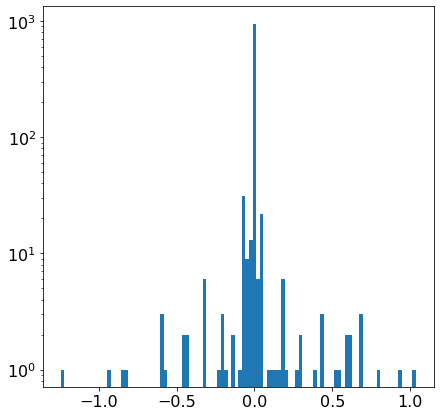

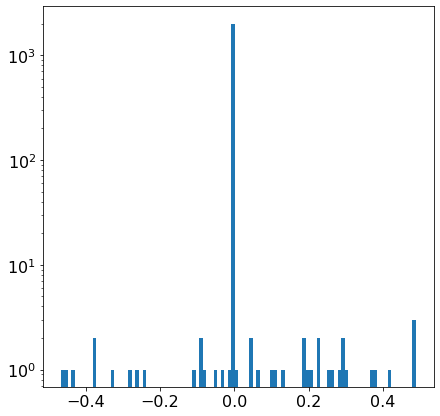

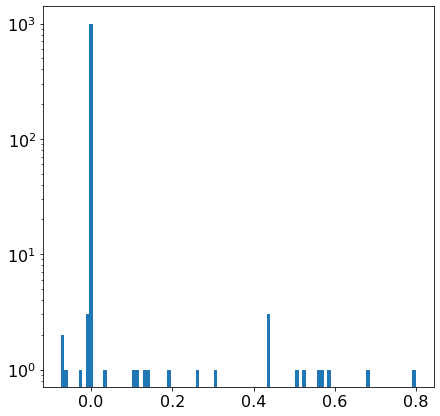

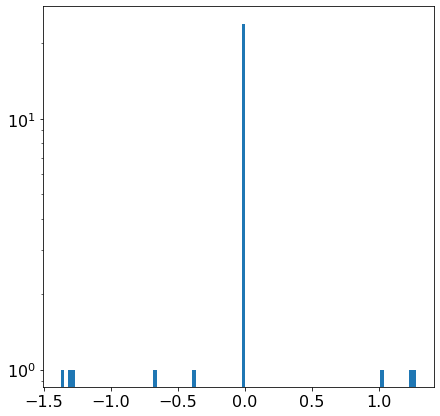

In [126]:
w = models_pruned["3_layers"].layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

w = models_pruned["3_layers"].layers[2].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

w = models_pruned["3_layers"].layers[4].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

w = models_pruned["3_layers"].layers[6].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

% of zeros = 0.25


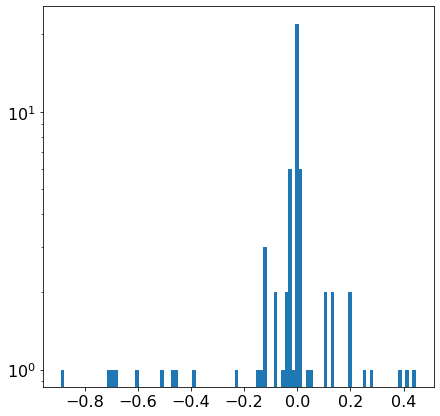

In [127]:
w = models_pruned["4_nodes"].layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))


In [128]:
y_qkeras = {}

for label in models_pruned:
    y_qkeras[label] = models_pruned[label].predict((X_test))

1457/1457 [==============================] - 1s 496us/step


## Save the data

In [129]:
for label in models_pruned:
    qkeras_data_file = "Data/y_qkeras_" + label + "_" + lep_class + "_" + act + "_480.npy"
    np.save(qkeras_data_file, y_qkeras[label])

In [130]:
import plotting
from sklearn.metrics import accuracy_score

In [131]:

y_qkeras

{'3_layers': array([[1.7952798e-04],
        [9.9752736e-01],
        [1.7952798e-04],
        ...,
        [6.2633422e-04],
        [9.9883050e-01],
        [6.2633422e-04]], dtype=float32),
 '2_layers': array([[2.0988309e-04],
        [9.9648935e-01],
        [1.2731104e-04],
        ...,
        [1.2160416e-03],
        [9.9854493e-01],
        [7.7936606e-04]], dtype=float32),
 '1_layer': array([[3.9204181e-04],
        [9.9435806e-01],
        [1.7952798e-04],
        ...,
        [9.6975197e-04],
        [9.9934876e-01],
        [1.5978455e-03]], dtype=float32),
 '4_nodes': array([[3.5143827e-04],
        [9.9073201e-01],
        [2.6426834e-04],
        ...,
        [8.5256668e-04],
        [9.9573535e-01],
        [4.8217614e-04]], dtype=float32)}

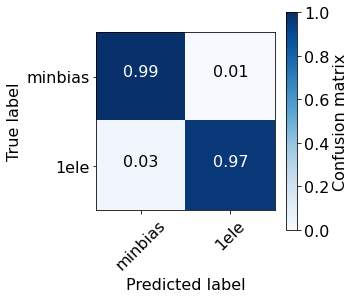

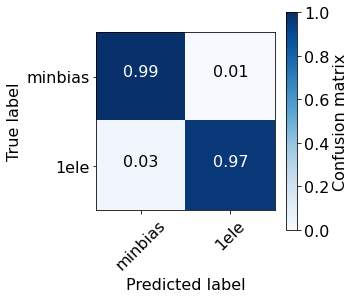

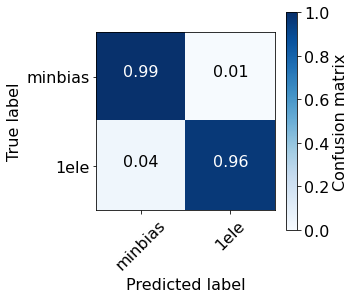

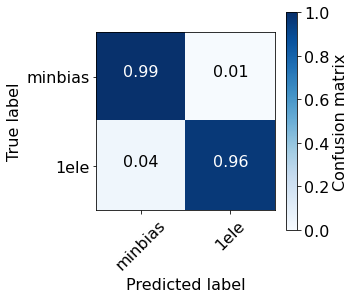

In [135]:
le = LabelEncoder()
y_temp = df_all['type']
y_copy = np.copy(y_temp)
#y_copy[y_copy!=lep_class] = 'other'
y_copy = le.fit_transform(y_copy)
y_copy = to_categorical(y_copy, len(np.unique(y_copy)))
class_index = np.where(le.classes_==lep_class)[0]
y_copy = y_copy[:,class_index]
classes = le.classes_

thr = 0.5

for label in models_pruned:
    y_temp = np.copy(y_qkeras[label])
    y_temp[y_qkeras[label]>=thr]  = 1
    y_temp[y_qkeras[label]<thr] = 0
    plt.figure(figsize = (4,4))
    #cm = plotting.confusion_matrix(y_test, (y_qkeras[label]+1)/2)
    cm = plotting.confusion_matrix(y_test, y_temp)
    plotting.plot_confusion_matrix(cm, (classes[1],classes[0]), normalize=True)

In [136]:
(np.int16(y_qkeras["3_layers"]*256))[:20]

array([[  0],
       [255],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [251],
       [  0],
       [  1],
       [  1],
       [  0],
       [120],
       [  0],
       [255],
       [  0],
       [255],
       [  0],
       [  1]], dtype=int16)

Accuracy pruned, quantized: 0.9884793615378015
0.9793543686844937
Accuracy pruned, quantized: 0.9888440744872565
0.9796249657434178
Accuracy pruned, quantized: 0.9893589633570754
0.9794103908494538
Accuracy pruned, quantized: 0.988050287479619
0.9775814362636628


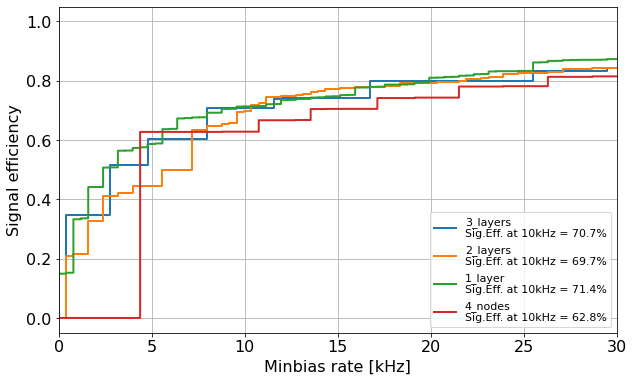

In [148]:
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score

f,ax1  = plt.subplots(figsize = (10,6))
legend_size = 14   
lim=20

rocs_qkeras = {}
thr_Q = 1/2**1

for label in models_pruned:
    #y_temp_qkeras = (np.copy(y_qkeras[label]) + 1)/2
    y_temp_qkeras = np.copy(y_qkeras[label])
    y_temp_qkeras[y_qkeras[label]>=thr_Q]  = 1.
    y_temp_qkeras[y_qkeras[label]<thr_Q] = 0.
    
    #print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
    print("Accuracy pruned, quantized: {}".format(accuracy_score(y_test, y_temp_qkeras)))
    
    print(roc_auc_score(y_test, y_temp_qkeras))
    
    rocs_qkeras = roc_curve(y_test, y_qkeras[label])
    
    index = np.abs(rocs_qkeras[0]*minbias_rate - 10).argmin()
    sig_eff_qkeras= rocs_qkeras[1][index]
    eff_string_qkeras= "Sig.Eff. at 10kHz = {}%".format(round(sig_eff_qkeras*100,1))
    ax1.plot(rocs_qkeras[0]*minbias_rate,rocs_qkeras[1],"-",label=label+"\n"+eff_string_qkeras,lw=2, drawstyle='steps-mid')

    #plt.plot(rocs_hls[0],rocs_hls[1]*minbias_rate,"--",label="hls")

    ax1.legend(prop={'size': 11},loc = "lower right")
    ax1.set_xlabel("Minbias rate [kHz]")
    ax1.set_ylabel("Signal efficiency")

    #plt.yscale("log")
    ax1.set_xlim(0,30)
    #plt.ylim(0,20)
    ax1.grid(True)


In [141]:
for label in models:
    models_pruned[label] = load_trained_model_pruned(model_path="binary/" + label + "/" + lep_class + "NN_" + act )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qfc1 (QDense)               (None, 64)                1152      
                                                                 
 q_relu_1 (QActivation)      (None, 64)                0         
                                                                 
 qfc2 (QDense)               (None, 32)                2080      
                                                                 
 q_relu_2 (QActivation)      (None, 32)                0         
                                                                 
 qfc3 (QDense)               (None, 32)                1056      
                                                                 
 q_relu_3 (QActivation)      (None, 32)                0         
                                                                 
 output (QDense)             (None, 1)                 3

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qfc1 (QDense)               (None, 64)                1152      
                                                                 
 q_relu_1 (QActivation)      (None, 64)                0         
                                                                 
 qfc2 (QDense)               (None, 32)                2080      
                                                                 
 q_relu_2 (QActivation)      (None, 32)                0         
                                                                 
 output (QDense)             (None, 1)                 33        
                                                                 
 sigmoid (Activation)        (None, 1)                 0         
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-traina

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qfc1 (QDense)               (None, 64)                1152      
                                                                 
 q_relu_1 (QActivation)      (None, 64)                0         
                                                                 
 output (QDense)             (None, 1)                 65        
                                                                 
 sigmoid (Activation)        (None, 1)                 0         
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qfc1 (QDense)               (None, 4)                 72        
                                                                 
 q_relu_1 (QActivation)      (None, 4)                 0         
                                                                 
 output (QDense)             (None, 1)                 5         
                                                                 
 sigmoid (Activation)        (None, 1)                 0         
                                                                 
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


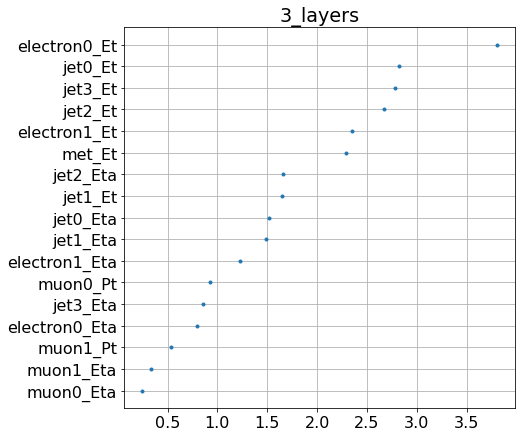

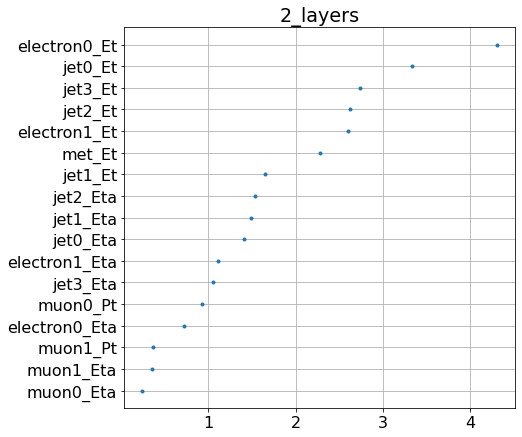

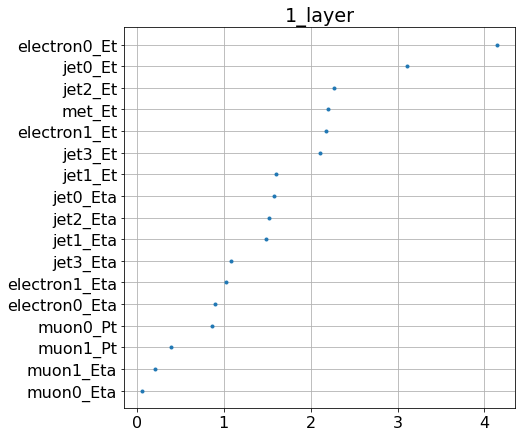

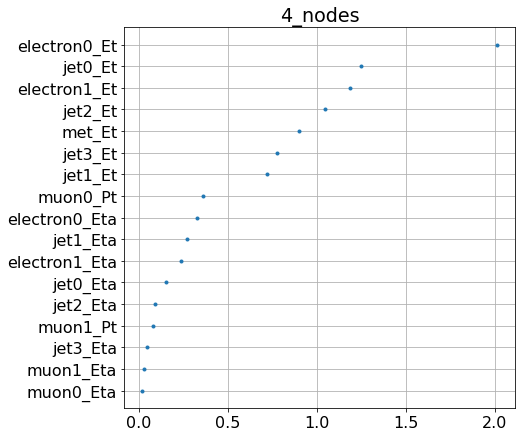

In [178]:
w_input = {}
for label in models_pruned:
    w_input[label] = models_pruned[label].layers[0].weights[0].numpy()

for label in models_pruned:
    plt.figure(figsize=(7,7))
    plt.title(label)
    wi_abs_mean = np.sum(np.abs(w_input[label]), axis=1)
    sorted_index = np.argsort(wi_abs_mean)
    wi_abs_mean[sorted_index]
    var_names_sorted = [var_names_small[i] for i in sorted_index]
    plt.plot(wi_abs_mean[sorted_index], var_names_sorted, '.')
    plt.grid(True)
    img_title = PLOT_PATH + 'Input_weights ' + label + '_'+ lep_class + '_' + act +'.pdf' 
    plt.savefig(img_title, bbox_inches='tight')

/home/gbortola/anaconda3/envs/hls4ml_env/lib/python3.8/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


Interpreting Sequential
Topology:
Layer name: qfc1_input, layer type: Input
Layer name: qfc1, layer type: QDense
Layer name: q_relu_1, layer type: QActivation
Layer name: qfc2, layer type: QDense
Layer name: q_relu_2, layer type: QActivation
Layer name: qfc3, layer type: QDense
Layer name: q_relu_3, layer type: QActivation
Layer name: output, layer type: QDense
Layer name: sigmoid, layer type: Activation
-----------------------------------
Model
  ReuseFactor:       1
  Strategy:          Latency
  Precision:         ap_fixed<16,8>
LayerName
  qfc1_input
    Precision
      result:        ap_fixed<16,6>
    Strategy:        Latency
    ReuseFactor:     1
    Trace:           True
  qfc1
    Precision
      weight:        ap_fixed<6,3>
      bias:          ap_fixed<6,3>
    ReuseFactor:     1
    Strategy:        Latency
    Trace:           True
  q_relu_1
    Precision
      result:        ap_ufixed<3,1>
    ReuseFactor:     1
    Strategy:        Latency
    Trace:           True
  q

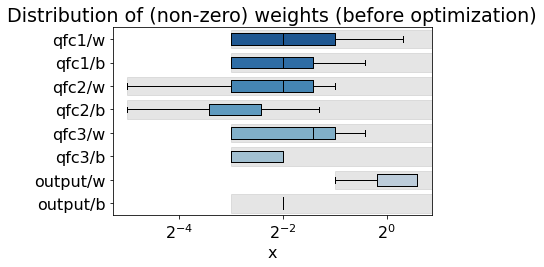

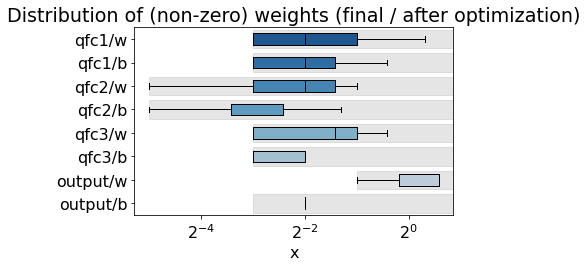

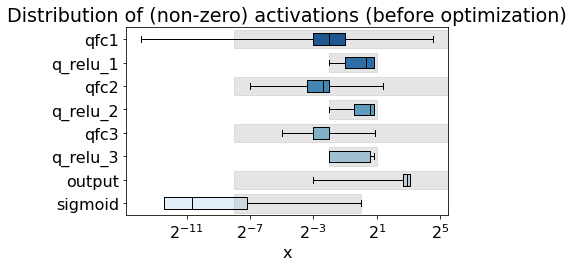

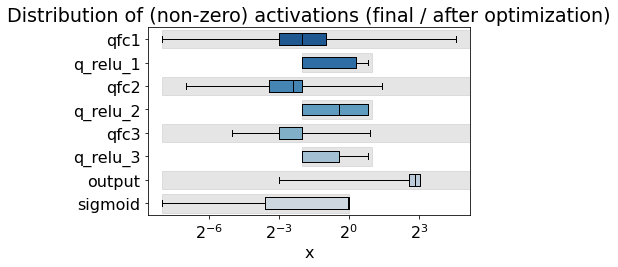

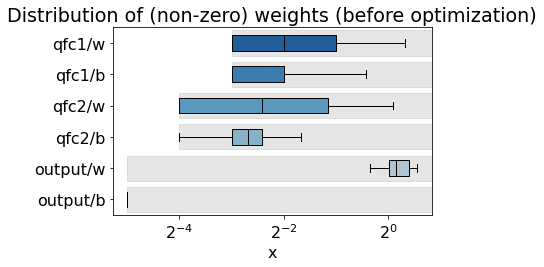

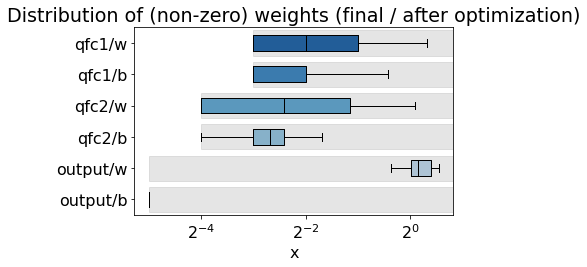

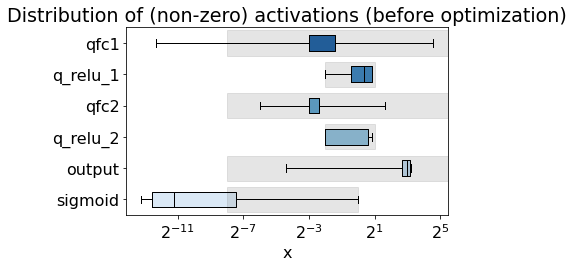

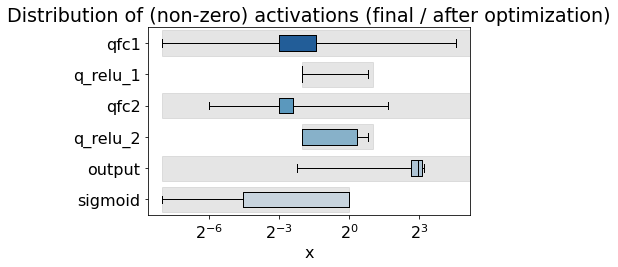

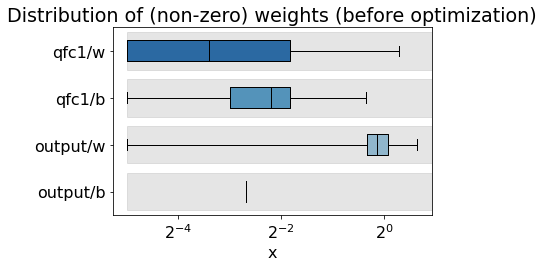

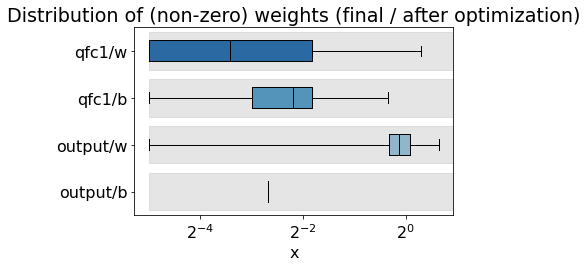

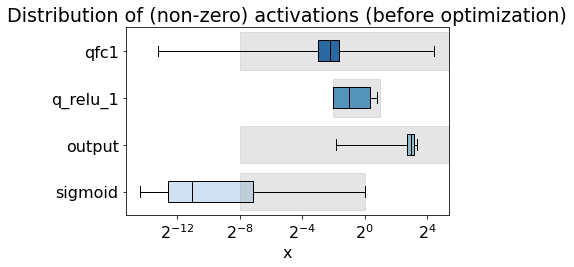

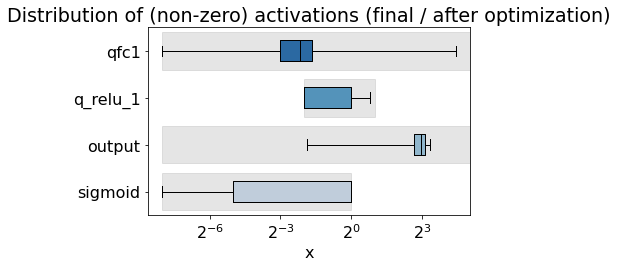

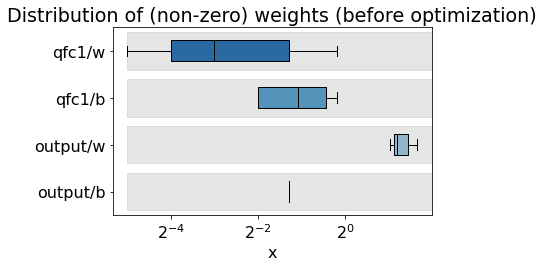

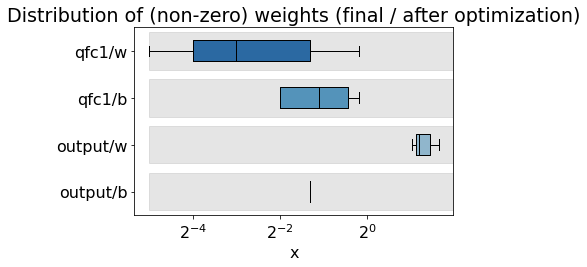

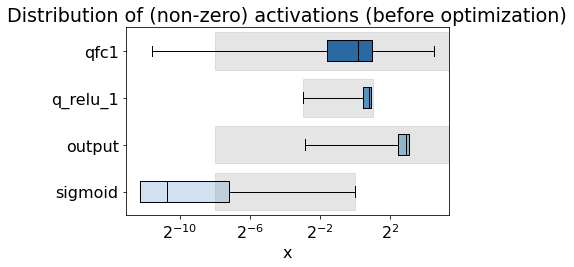

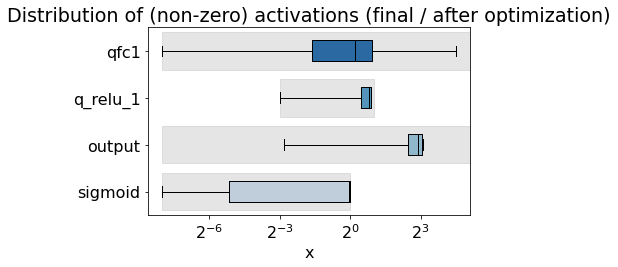

In [143]:
import hls4ml
import plotting


hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

Trace        = True

clock_period = 4.167 #240MHz

hls_model = {}

for label in models_pruned:
    
    hls4ml_model_path = "projects/binary/" + label + "_" + lep_class + "_" + act 

    config = hls4ml.utils.config_from_keras_model(models_pruned[label], granularity='name')


    config['Model'] = {}
    config['Model']['ReuseFactor'] = 1
    config['Model']['Strategy'] = 'Latency'
    config['Model']['Precision'] = 'ap_fixed<16,8>'
    #config['Optimizers']     = ['eliminate_linear_activation']

    #config['LayerName']['input_1']['Trace']       = Trace

    for Layer in config['LayerName'].keys():
        #config['LayerName'][Layer]['Precision']['weight']   = 'ap_fixed<2,1>'
        #config['LayerName'][Layer]['Precision']['bias']     = 'ap_fixed<11,3>'
        config['LayerName'][Layer]['Strategy'] = 'Latency'
        config['LayerName'][Layer]['ReuseFactor'] = 1
        config['LayerName'][Layer]['Trace']     = Trace

    config['LayerName']['output']['ReuseFactor'] = 1
    #config['LayerName']['output']['Precision']['weight']   = 'ap_fixed<6,5>'
    #config['LayerName']['output']['Precision']['bias']     = 'ap_fixed<4,1>'
    #config['LayerName']['output']['Precision']['result']   = 'ap_fixed<16,6>'
    config['LayerName']['output']['Strategy'] = 'Latency'
    
    if act == 'softmax':
        config['LayerName'][act]['exp_table_t'] = 'ap_fixed<12,4>'
        config['LayerName'][act]['inv_table_t'] = 'ap_fixed<12,2>'
        config['LayerName'][act]['table_size']  = 1024
        config['LayerName'][act]['Precision']   = 'ap_ufixed<10,0>'
        config['LayerName'][act]['Strategy']    = 'Stable'
    elif act == 'sigmoid':
        config['LayerName'][act]['table_t']    = 'ap_fixed<12,4>'
        config['LayerName'][act]['table_size']  = 512
        config['LayerName'][act]['Precision']  = 'ap_ufixed<8,0>' 
            



    print("-----------------------------------")
    plotting.print_dict(config)
    print("-----------------------------------")
    hls_model[label] = hls4ml.converters.convert_from_keras_model(models_pruned[label],
                                                           clock_period= clock_period,
                                                           hls_config=config,
                                                           output_dir=hls4ml_model_path,
                                                           part='xcvu9p-flga2104-2L-e')


    hls4ml.model.profiling.numerical(model=models_pruned[label], hls_model=hls_model[label], X=X_test[:1000])

In [144]:
y_hls = {}

for label in models_pruned:
    #hls_model[label].compile()
    y_hls[label] = hls_model[label].predict(np.ascontiguousarray(X_test))

In [145]:
np.stack((y_qkeras["1_layer"],y_hls["1_layer"], y_test), axis=-1)[2100:2130]

array([[[1.82354604e-04, 0.00000000e+00, 0.00000000e+00]],

       [[1.97169429e-04, 0.00000000e+00, 0.00000000e+00]],

       [[4.29793913e-03, 3.90625000e-03, 0.00000000e+00]],

       [[8.44927579e-02, 8.20312500e-02, 0.00000000e+00]],

       [[9.68560853e-05, 0.00000000e+00, 0.00000000e+00]],

       [[1.14244944e-03, 0.00000000e+00, 0.00000000e+00]],

       [[9.99328077e-01, 9.96093750e-01, 1.00000000e+00]],

       [[1.03102124e-04, 0.00000000e+00, 0.00000000e+00]],

       [[6.66702341e-04, 0.00000000e+00, 0.00000000e+00]],

       [[3.39827627e-01, 3.39843750e-01, 0.00000000e+00]],

       [[9.99348760e-01, 9.96093750e-01, 1.00000000e+00]],

       [[2.26933858e-04, 0.00000000e+00, 0.00000000e+00]],

       [[2.51186779e-04, 0.00000000e+00, 0.00000000e+00]],

       [[2.38708351e-02, 2.34375000e-02, 0.00000000e+00]],

       [[9.98848617e-01, 9.96093750e-01, 1.00000000e+00]],

       [[1.94113192e-04, 0.00000000e+00, 0.00000000e+00]],

       [[3.30152747e-04, 0.00000000e+00,

--------------------3_layers--------------------
Accuracy pruned, quantized: 0.9884793615378015
Accuracy hls4ml: 0.98875825967562
AUC pruned, quantized: 0.9793543686844937
AUC hls4ml: 0.9788416924478349
--------------------2_layers--------------------
Accuracy pruned, quantized: 0.9888440744872565
Accuracy hls4ml: 0.9888226207843474
AUC pruned, quantized: 0.9796249657434178
AUC hls4ml: 0.9798735178947714
--------------------1_layer--------------------
Accuracy pruned, quantized: 0.9893589633570754
Accuracy hls4ml: 0.9893804170599846
AUC pruned, quantized: 0.9794103908494538
AUC hls4ml: 0.9796846274925115
--------------------4_nodes--------------------
Accuracy pruned, quantized: 0.988050287479619
Accuracy hls4ml: 0.9881361022912555
AUC pruned, quantized: 0.9775814362636628
AUC hls4ml: 0.978992056112539


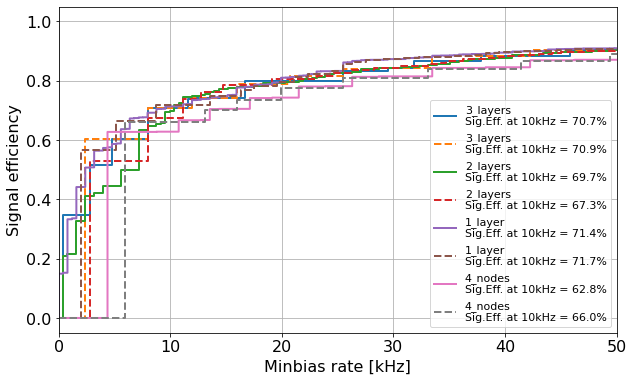

In [159]:
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score

f,ax1  = plt.subplots(figsize = (10,6))
legend_size = 14   
lim=20

rocs_qkeras = {}
rocs_hls    = {}

thr_Q = 1/2**1
thr_H = 1/2**1

for label in models_pruned:
    #y_temp_qkeras = (np.copy(y_qkeras[label]) + 1)/2
    y_temp_qkeras = np.copy(y_qkeras[label])
    y_temp_qkeras[y_qkeras[label]>=thr_Q]  = 1.
    y_temp_qkeras[y_qkeras[label]<thr_Q] = 0.
    
    #y_temp_hls = (np.copy(y_hls[label]) + 1)/2
    y_temp_hls = np.copy(y_hls[label])
    y_temp_hls[y_hls[label]>=thr_H]  = 1.
    y_temp_hls[y_hls[label]<thr_H] = 0.
    
    print("--------------------" + label + "--------------------")
    #print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
    print("Accuracy pruned, quantized: {}".format(accuracy_score(y_test, y_temp_qkeras)))
    print("Accuracy hls4ml: {}".format(accuracy_score(y_test, y_temp_hls)))
    
    print("AUC pruned, quantized: {}".format(roc_auc_score(y_test, y_temp_qkeras)))
    print("AUC hls4ml: {}".format(roc_auc_score(y_test, y_temp_hls   )))
    
    rocs_qkeras = roc_curve(y_test, y_qkeras[label])
    rocs_hls    = roc_curve(y_test, y_hls[label]   )
    
    index = np.abs(rocs_qkeras[0]*minbias_rate - 10).argmin()
    sig_eff_qkeras= rocs_qkeras[1][index]
    index = np.abs(rocs_hls[0]*minbias_rate - 10).argmin()
    sig_eff_hls   = rocs_hls[1][index]
    eff_string_qkeras= "Sig.Eff. at 10kHz = {}%".format(round(sig_eff_qkeras*100,1))
    eff_string_hls= "Sig.Eff. at 10kHz = {}%".format(round(sig_eff_hls*100,1))
    ax1.plot(rocs_qkeras[0]*minbias_rate,rocs_qkeras[1],"-",label=label+"\n"+eff_string_qkeras,lw=2, drawstyle='steps-mid')
    ax1.plot(rocs_hls[0]*minbias_rate,rocs_hls[1],"--",label=label+"\n"+eff_string_hls,lw=2, drawstyle='steps-mid')
    #plt.plot(rocs_qkeras[0],rocs_qkeras[1]*minbias_rate,"-",label="qkeras")

    #plt.plot(rocs_hls[0],rocs_hls[1]*minbias_rate,"--",label="hls")

    ax1.legend(prop={'size': 11},loc = "lower right")
    ax1.set_xlabel("Minbias rate [kHz]")
    ax1.set_ylabel("Signal efficiency")

    #plt.yscale("log")
    ax1.set_xlim(0,50)
    #plt.ylim(0,20)
    ax1.grid(True)

plt.show()

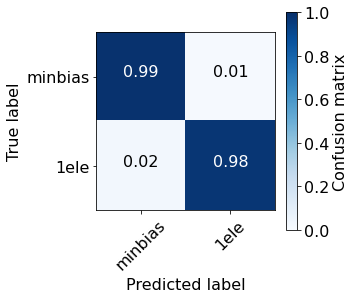

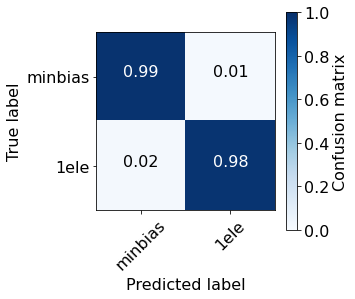

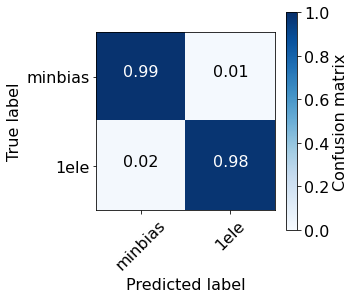

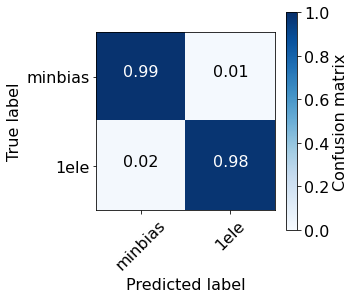

In [160]:
le = LabelEncoder()
y_temp = le.fit_transform(df_all["type"])
classes = le.classes_
classes

thr  = 1/2**2

for label in models_pruned:
    y_temp_qkeras[y_qkeras[label]<thr] = 0
    
    #y_temp_hls = (np.copy(y_hls[label]) + 1)/2
    y_temp_hls = np.copy(y_hls[label])
    y_temp_hls[y_hls[label]>=thr]  = 1.
    y_temp_hls[y_hls[label]<thr] = 0.
    
    plt.figure(figsize = (4,4))
    cm = plotting.confusion_matrix(y_test, y_temp_hls)
    plotting.plot_confusion_matrix(cm, (classes[1], classes[0]), normalize=True)

In [83]:
for label in models_pruned:
    hls_model[label].build(export=True, vsynth=True)

In [161]:
for label in models_pruned:
    print("--------------------------------------------------------")
    print("------------------------" + label + "------------------------")
    print("--------------------------------------------------------")
    
    hls4ml.report.read_vivado_report("projects/binary/" + label + "_" + lep_class + "_" + act + "/")

--------------------------------------------------------
------------------------3_layers------------------------
--------------------------------------------------------
Found 1 solution(s) in projects/binary/3_layers_1ele_sigmoid//myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Compiling ../../../../firmware/myproject_axi.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0234375 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Fri Jun 10 13:49:49 2022

* Version:        2020.1 (Build 2897737 

## 480 MHz 

Interpreting Sequential
Topology:
Layer name: qfc1_input, layer type: Input
Layer name: qfc1, layer type: QDense
Layer name: q_relu_1, layer type: QActivation
Layer name: qfc2, layer type: QDense
Layer name: q_relu_2, layer type: QActivation
Layer name: qfc3, layer type: QDense
Layer name: q_relu_3, layer type: QActivation
Layer name: output, layer type: QDense
Layer name: sigmoid, layer type: Activation
-----------------------------------
Model
  ReuseFactor:       1
  Strategy:          Latency
  Precision:         ap_fixed<16,6>
LayerName
  qfc1_input
    Precision
      result:        ap_fixed<16,6>
    Strategy:        Latency
    ReuseFactor:     1
    Trace:           True
  qfc1
    Precision
      weight:        ap_fixed<6,3>
      bias:          ap_fixed<6,3>
    ReuseFactor:     1
    Strategy:        Latency
    Trace:           True
  q_relu_1
    Precision
      result:        ap_ufixed<3,1>
    ReuseFactor:     1
    Strategy:        Latency
    Trace:           True
  q

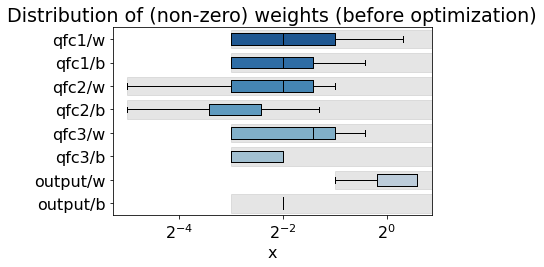

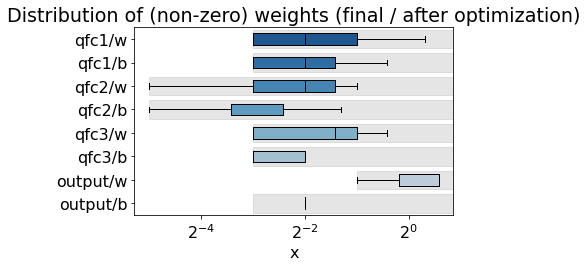

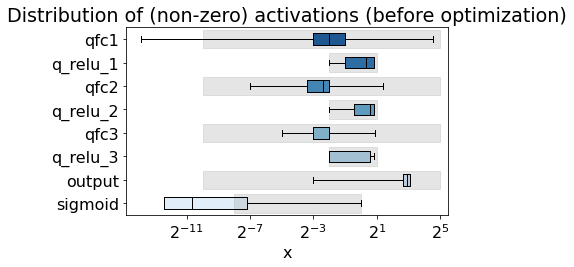

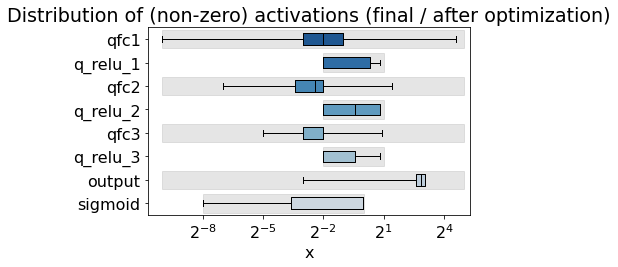

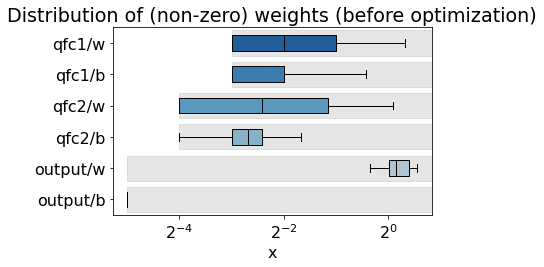

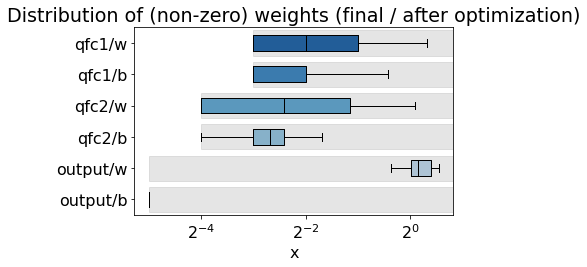

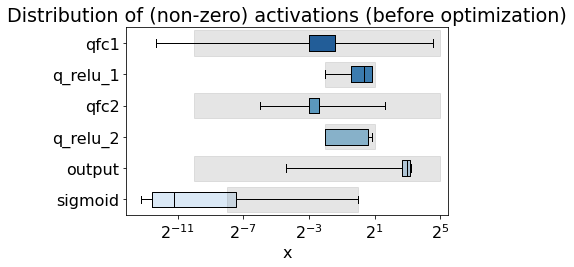

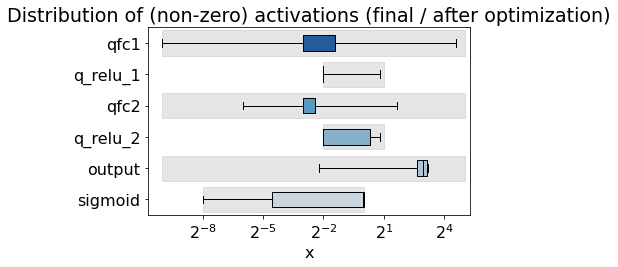

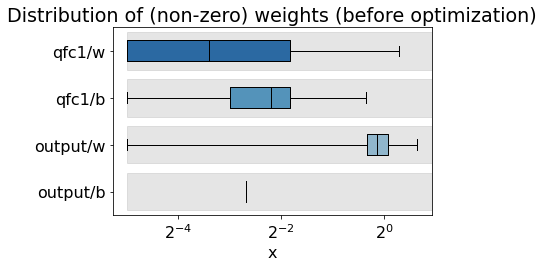

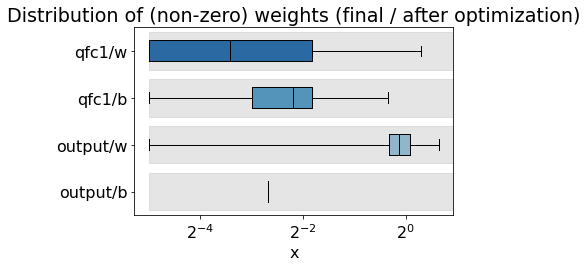

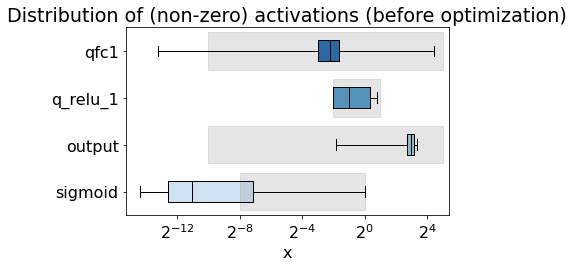

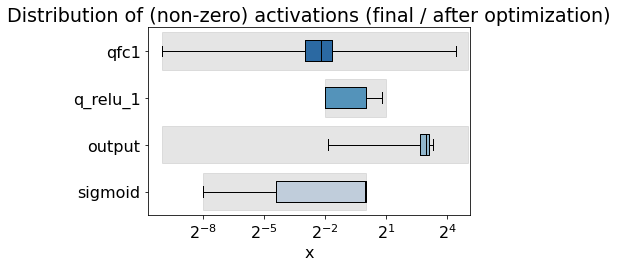

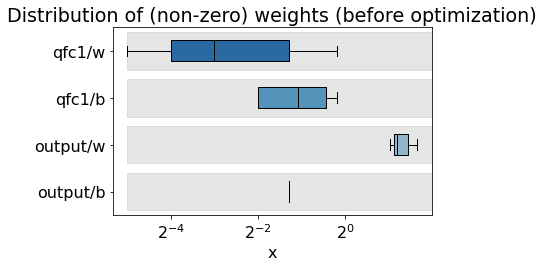

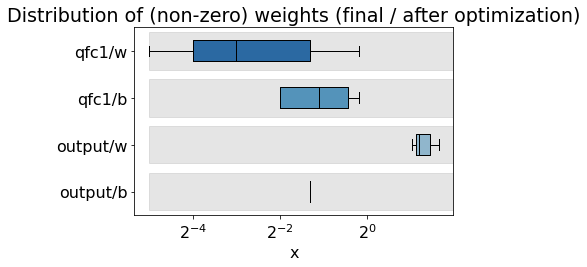

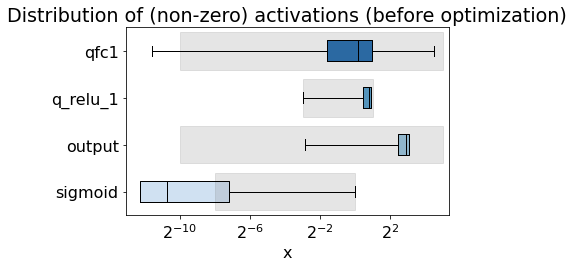

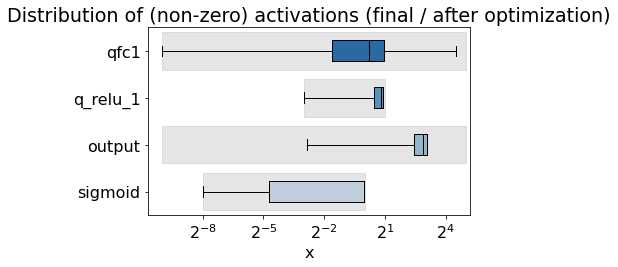

In [162]:
import hls4ml
import plotting


hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

Trace        = True

clock_period = (1/480-1) * 1000 

hls_model = {}

for label in models_pruned:
    
    hls4ml_model_path = "projects/binary/" + label + "_" + lep_class + "_" + act + "_480"

    config = hls4ml.utils.config_from_keras_model(models_pruned[label], granularity='name')


    config['Model'] = {}
    config['Model']['ReuseFactor'] = 1
    config['Model']['Strategy'] = 'Latency'
    config['Model']['Precision'] = 'ap_fixed<16,6>'
    #config['Optimizers']     = ['eliminate_linear_activation']

    #config['LayerName']['input_1']['Trace']       = Trace

    for Layer in config['LayerName'].keys():
        #config['LayerName'][Layer]['Precision']['weight']   = 'ap_fixed<2,1>'
        #config['LayerName'][Layer]['Precision']['bias']     = 'ap_fixed<11,3>'
        config['LayerName'][Layer]['Strategy'] = 'Latency'
        config['LayerName'][Layer]['ReuseFactor'] = 1
        config['LayerName'][Layer]['Trace']     = Trace

    config['LayerName']['output']['ReuseFactor'] = 1
    #config['LayerName']['output']['Precision']['weight']   = 'ap_fixed<6,5>'
    #config['LayerName']['output']['Precision']['bias']     = 'ap_fixed<4,1>'
    #config['LayerName']['output']['Precision']['result']   = 'ap_fixed<16,6>'
    config['LayerName']['output']['Strategy'] = 'Latency'
    
    if act == 'softmax':
        config['LayerName'][act]['exp_table_t'] = 'ap_fixed<12,4>'
        config['LayerName'][act]['inv_table_t'] = 'ap_fixed<12,2>'
        config['LayerName'][act]['table_size']  = 1024
        config['LayerName'][act]['Precision']   = 'ap_ufixed<10,0>'
        config['LayerName'][act]['Strategy']    = 'Stable'
    elif act == 'sigmoid':
        config['LayerName'][act]['table_t']    = 'ap_fixed<12,4>'
        config['LayerName'][act]['table_size']  = 512
        config['LayerName'][act]['Precision']  = 'ap_ufixed<8,0>' 
            



    print("-----------------------------------")
    plotting.print_dict(config)
    print("-----------------------------------")
    hls_model[label] = hls4ml.converters.convert_from_keras_model(models_pruned[label],
                                                           clock_period= clock_period,
                                                           hls_config=config,
                                                           output_dir=hls4ml_model_path,
                                                           part='xcvu9p-flga2104-2L-e')


    hls4ml.model.profiling.numerical(model=models_pruned[label], hls_model=hls_model[label], X=X_test[:1000])

In [182]:
X_test = np.load( DATA_PATH + "X_test_" + fname)
y_qkeras = {}

for label in models_pruned:
    y_qkeras[label] = models_pruned[label].predict((X_test))

1457/1457 [==============================] - 1s 468us/step


In [183]:
y_hls = {}

for label in models_pruned:
    #hls_model[label].compile()
    y_hls[label] = hls_model[label].predict(np.ascontiguousarray(X_test))
    hls_data_file = DATA_PATH + "y_hls_" + label + "_" + lep_class + "_" + act + "_480.npy"
    np.save(hls_data_file, y_hls[label])

---------------------3_layers---------------------
Accuracy pruned, quantized: 98.848%
Accuracy hls4ml           : 98.876%
AUC score pruned, quantized: 97.935%
AUC score hls4ml           : 97.868%
-------------------------------------------------
---------------------2_layers---------------------
Accuracy pruned, quantized: 98.884%
Accuracy hls4ml           : 98.889%
AUC score pruned, quantized: 97.962%
AUC score hls4ml           : 97.970%
-------------------------------------------------
---------------------1_layer---------------------
Accuracy pruned, quantized: 98.936%
Accuracy hls4ml           : 98.942%
AUC score pruned, quantized: 97.941%
AUC score hls4ml           : 97.961%
-------------------------------------------------
---------------------4_nodes---------------------
Accuracy pruned, quantized: 98.805%
Accuracy hls4ml           : 98.809%
AUC score pruned, quantized: 97.758%
AUC score hls4ml           : 97.902%
-------------------------------------------------


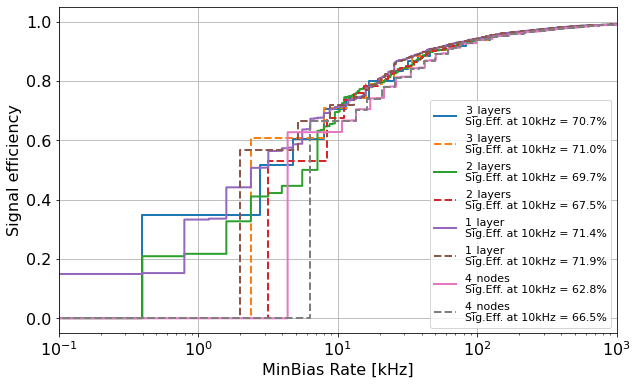

In [184]:
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score

f,ax1  = plt.subplots(figsize = (10,6))
legend_size = 14   
lim=20

rocs_qkeras = {}
rocs_hls    = {}

thr_Q = 1/2**1
thr_H = 1/2**1

for label in models_pruned:
    #y_temp_qkeras = (np.copy(y_qkeras[label]) + 1)/2
    y_temp_qkeras = np.copy(y_qkeras[label])
    y_temp_qkeras[y_qkeras[label]>=thr_Q]  = 1.
    y_temp_qkeras[y_qkeras[label]<thr_Q] = 0.
    
    #y_temp_hls = (np.copy(y_hls[label]) + 1)/2
    y_temp_hls = np.copy(y_hls[label])
    y_temp_hls[y_hls[label]>=thr_H]  = 1.
    y_temp_hls[y_hls[label]<thr_H] = 0.
    
    print("---------------------" + label + "---------------------")
    
    #print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
    print("Accuracy pruned, quantized: {:.3f}".format(accuracy_score(y_test, y_temp_qkeras)*100) + "%")
    print("Accuracy hls4ml           : {:.3f}".format(accuracy_score(y_test, y_temp_hls   )*100) + "%")
    
    print("AUC score pruned, quantized: {:.3f}".format(roc_auc_score(y_test, y_temp_qkeras)*100) + "%")
    print("AUC score hls4ml           : {:.3f}".format(roc_auc_score(y_test, y_temp_hls   )*100) + "%")
    
    print("-------------------------------------------------")
    
    
    rocs_qkeras = roc_curve(y_test, y_qkeras[label])
    rocs_hls    = roc_curve(y_test, y_hls[label]   )
    
    index = np.abs(rocs_qkeras[0]*minbias_rate - 10).argmin()
    sig_eff_qkeras= rocs_qkeras[1][index]
    index = np.abs(rocs_hls[0]*minbias_rate - 10).argmin()
    sig_eff_hls   = rocs_hls[1][index]
    eff_string_qkeras= "Sig.Eff. at 10kHz = {}%".format(round(sig_eff_qkeras*100,1))
    eff_string_hls= "Sig.Eff. at 10kHz = {}%".format(round(sig_eff_hls*100,1))
    ax1.plot(rocs_qkeras[0]*minbias_rate,rocs_qkeras[1],"-",label=label+"\n"+eff_string_qkeras,lw=2, drawstyle='steps-mid')
    ax1.plot(rocs_hls[0]*minbias_rate,rocs_hls[1],"--",label=label+"\n"+eff_string_hls,lw=2, drawstyle='steps-mid')
    #plt.plot(rocs_qkeras[0],rocs_qkeras[1]*minbias_rate,"-",label="qkeras")

    #plt.plot(rocs_hls[0],rocs_hls[1]*minbias_rate,"--",label="hls")

    ax1.legend(prop={'size': 11},loc = "lower right")
    ax1.set_xlabel("MinBias Rate [kHz]")
    ax1.set_ylabel("Signal efficiency")

    ax1.set_xscale("log")
    ax1.set_xlim(0.1,1000)
    #plt.ylim(0,20)
    ax1.grid(True)

plt.show()

In [90]:
for label in models_pruned:
    hls_model[label].build(export=True, vsynth=True)

In [167]:
for label in models_pruned:
    print("--------------------------------------------------------")
    print("------------------------" + label + "------------------------")
    print("--------------------------------------------------------")
    
    hls4ml.report.read_vivado_report("projects/binary/" + label + "_" + lep_class + "_" + act + "_480" + "/")

--------------------------------------------------------
------------------------3_layers------------------------
--------------------------------------------------------
Found 1 solution(s) in projects/binary/3_layers_1ele_sigmoid_480//myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0234375 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Tue May 31 16:41:36 2022

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_p

In [168]:
from pathlib import Path
import pprint 


def getReports(indir, clock_freq):
    data_ = {}
    
    report_vsynth = Path('{}/vivado_synth.rpt'.format(indir))
    report_csynth = Path('{}/myproject_prj/solution1/syn/report/myproject_csynth.rpt'.format(indir))
    
    if report_vsynth.is_file() and report_csynth.is_file():
    #if report_csynth.is_file():
        print('Found valid vsynth and synth in {}! Fetching numbers'.format(indir))
        
        # Get the resources from the logic synthesis report 
        with report_vsynth.open() as report:
            lines = np.array(report.readlines())
            data_['lut']     = int(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[2])
            data_['ff']      = int(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[2])
            data_['bram']    = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[2])
            data_['dsp']     = int(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[2])
            #data_['lut_rel'] = float(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[5])
            #data_['ff_rel']  = float(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[5])
            #data_['bram_rel']= float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[5])
            #data_['dsp_rel'] = float(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[5])
        
        with report_csynth.open() as report:
            lines = np.array(report.readlines())
            lat_line = lines[np.argwhere(np.array(['Latency (cycles)' in line for line in lines])).flatten()[0] + 3]
            data_['latency_clks'] = int(lat_line.split('|')[2])
            data_['latency_ns']  = float(lat_line.split('|')[2])*1000/clock_freq
            data_['latency_ii']   = int(lat_line.split('|')[6])
    
    return data_


In [169]:
data_240 = {}
data_480 = {}

for label in models_pruned:
    data_240[label] = getReports("projects/binary/" + label + "_" + lep_class + "_" + act, 240)
    data_480[label] = getReports("projects/binary/" + label + "_" + lep_class + "_" + act + "_480", 480)
    
    pprint.pprint(data_240[label])
    pprint.pprint(data_480[label])

Found valid vsynth and synth in projects/binary/3_layers_1ele_sigmoid! Fetching numbers
Found valid vsynth and synth in projects/binary/3_layers_1ele_sigmoid_480! Fetching numbers
{'bram': 0.5,
 'dsp': 0,
 'ff': 608,
 'latency_clks': 8,
 'latency_ii': 1,
 'latency_ns': 33.333333333333336,
 'lut': 2210}
{'bram': 0.5,
 'dsp': 0,
 'ff': 1860,
 'latency_clks': 16,
 'latency_ii': 1,
 'latency_ns': 33.333333333333336,
 'lut': 2563}
Found valid vsynth and synth in projects/binary/2_layers_1ele_sigmoid! Fetching numbers
Found valid vsynth and synth in projects/binary/2_layers_1ele_sigmoid_480! Fetching numbers
{'bram': 0.5,
 'dsp': 0,
 'ff': 634,
 'latency_clks': 8,
 'latency_ii': 1,
 'latency_ns': 33.333333333333336,
 'lut': 2226}
{'bram': 0.5,
 'dsp': 0,
 'ff': 2039,
 'latency_clks': 14,
 'latency_ii': 1,
 'latency_ns': 29.166666666666668,
 'lut': 2159}
Found valid vsynth and synth in projects/binary/1_layer_1ele_sigmoid! Fetching numbers
Found valid vsynth and synth in projects/binary/1_lay

In [170]:
LUTs_240 = np.array([])
DSPs_240 = np.array([])
FFs_240  = np.array([])
lat_240  = np.array([])
lat_ns_240 = np.array([])

LUTs_480 = np.array([])
DSPs_480 = np.array([])
FFs_480  = np.array([])
lat_480  = np.array([])
lat_ns_480 = np.array([])

for label in models_pruned:
    if data_480[label] !={}:
        LUTs_240   = np.append(LUTs_240   , data_240[label]['lut']         )
        DSPs_240   = np.append(DSPs_240   , data_240[label]['dsp']         )
        FFs_240    = np.append(FFs_240    , data_240[label]['ff']          )
        lat_240    = np.append(lat_240    , data_240[label]['latency_clks'])
        lat_ns_240 = np.append(lat_ns_240 , data_240[label]['latency_ns']  )
    else:
        LUTs_240   = np.append(LUTs_240  , 0)
        DSPs_240   = np.append(DSPs_240  , 0)
        FFs_240    = np.append(FFs_240   , 0)
        lat_240    = np.append(lat_240   , 0)
        lat_ns_240 = np.append(lat_ns_240, 0)
        
    if data_480[label] !={}:
        LUTs_480   = np.append(LUTs_480   , data_480[label]['lut']         )
        DSPs_480   = np.append(DSPs_480   , data_480[label]['dsp']         )
        FFs_480    = np.append(FFs_480    , data_480[label]['ff']          )
        lat_480    = np.append(lat_480    , data_480[label]['latency_clks'])
        lat_ns_480 = np.append(lat_ns_480 , data_480[label]['latency_ns']  )
    else:
        LUTs_480   = np.append(LUTs_480  , 0)
        DSPs_480   = np.append(DSPs_480  , 0)
        FFs_480    = np.append(FFs_480   , 0)
        lat_480    = np.append(lat_480   , 0)
        lat_ns_480 = np.append(lat_ns_480, 0)

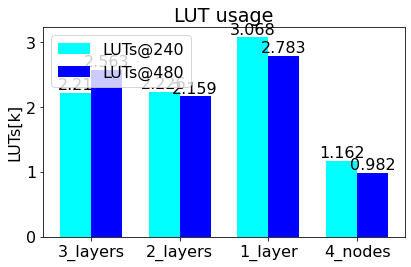

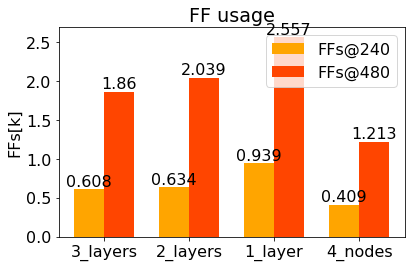

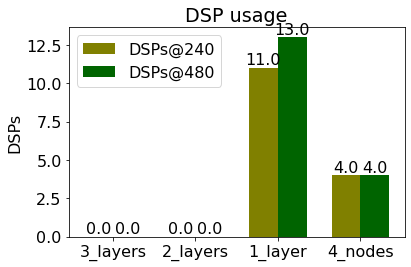

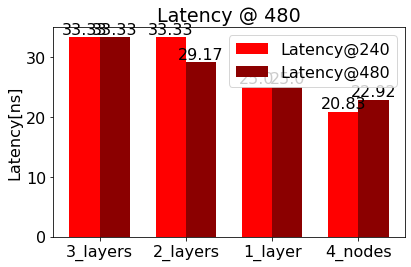

In [179]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0.5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

labels = list(models_pruned.keys())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rectsL_240 = ax.bar(x-width/2, LUTs_240/1e3, width, label='LUTs@240', color="cyan")
rectsL_480 = ax.bar(x+width/2, LUTs_480/1e3, width, label='LUTs@480', color="blue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('LUTs[k]')
ax.set_title('LUT usage')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()




autolabel(rectsL_240)
autolabel(rectsL_480)
fig.savefig(PLOT_PATH + 'LUT_usage_@480.pdf', bbox_inches='tight')
fig.tight_layout()

plt.show()

fig, ax = plt.subplots()
rectsF_240 = ax.bar(x-width/2, FFs_240/1e3, width, label='FFs@240', color="orange")
rectsF_480 = ax.bar(x+width/2, FFs_480/1e3, width, label='FFs@480', color="orangered")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('FFs[k]')
ax.set_title('FF usage')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()




autolabel(rectsF_240)
autolabel(rectsF_480)

fig.tight_layout()
fig.savefig( PLOT_PATH + 'FF_usage_@480.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
rectsD_240 = ax.bar(x-width/2, DSPs_240, width, label='DSPs@240', color="olive")
rectsD_480 = ax.bar(x+width/2, DSPs_480, width, label='DSPs@480', color="darkgreen")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('DSPs')
ax.set_title('DSP usage')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rectsD_240)
autolabel(rectsD_480)

fig.tight_layout()
fig.savefig( PLOT_PATH + 'DSP_usage_@480.pdf', bbox_inches='tight')
plt.show()

plt.show()

fig, ax = plt.subplots()
rectslat_240 = ax.bar(x-width/2, np.round(lat_ns_240,2), width, label='Latency@240', color="red")
rectslat_480 = ax.bar(x+width/2, np.round(lat_ns_480,2), width, label='Latency@480', color="darkred")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Latency[ns]')
ax.set_title('Latency @ 480')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rectslat_240)
autolabel(rectslat_480)

fig.tight_layout()
fig.savefig (PLOT_PATH + 'Latency_@480.pdf', bbox_inches='tight')
plt.show()

In [172]:
LUTs_impl_480 = np.array([3484, 3059, 3845, 1444] )
DSPs_impl_480 = np.array([0., 0., 13., 4.])
FFs_impl_480  = np.array([1858, 2046, 2887, 1308])

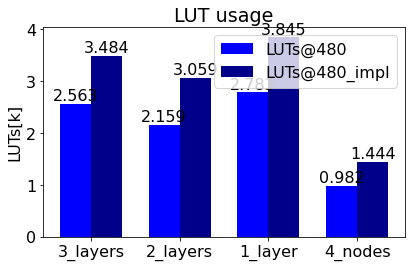

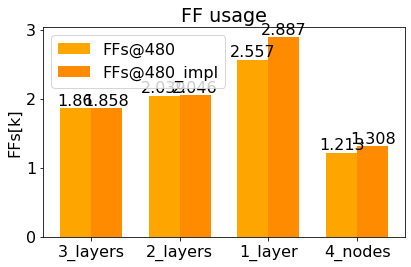

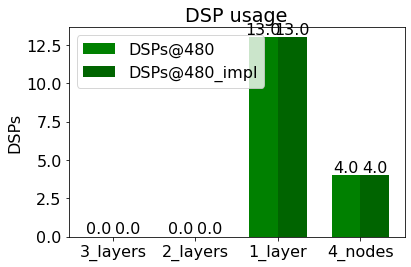

In [180]:
labels = list(models_pruned.keys())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rectsL_480   = ax.bar(x-width/2, LUTs_480/1e3, width, label='LUTs@480', color="blue")
rectsL_480_i = ax.bar(x+width/2, LUTs_impl_480/1e3, width, label='LUTs@480_impl', color="darkblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('LUTs[k]')
ax.set_title('LUT usage')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()




autolabel(rectsL_480)
autolabel(rectsL_480_i)
fig.savefig( PLOT_PATH + 'LUT_usage_@480_impl.pdf', bbox_inches='tight')
fig.tight_layout()

plt.show()

fig, ax = plt.subplots()
rectsF_480   = ax.bar(x-width/2, FFs_480/1e3, width, label='FFs@480', color="orange")
rectsF_480_i = ax.bar(x+width/2, FFs_impl_480/1e3, width, label='FFs@480_impl', color="darkorange")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('FFs[k]')
ax.set_title('FF usage')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()




autolabel(rectsF_480)
autolabel(rectsF_480_i)

fig.tight_layout()
fig.savefig( PLOT_PATH + 'FF_usage_@480_impl.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
rectsD_480   = ax.bar(x-width/2, DSPs_480, width, label='DSPs@480', color="green")
rectsD_480_i = ax.bar(x+width/2, DSPs_impl_480, width, label='DSPs@480_impl', color="darkgreen")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('DSPs')
ax.set_title('DSP usage')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rectsD_480)
autolabel(rectsD_480_i)

fig.tight_layout()
fig.savefig( PLOT_PATH + 'DSP_usage_@480_impl.pdf', bbox_inches='tight')
plt.show()

plt.show()